<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_generators_and_1_Classifier_ver6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files


In [202]:
!wget "https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5"

--2018-12-04 18:40:02--  https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘model2001s (1).h5.10’

model2001s (1).h5.1     [  <=>               ]  52.65K   148KB/s    in 0.4s    

2018-12-04 18:40:03 (148 KB/s) - ‘model2001s (1).h5.10’ saved [53917]



In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
    plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

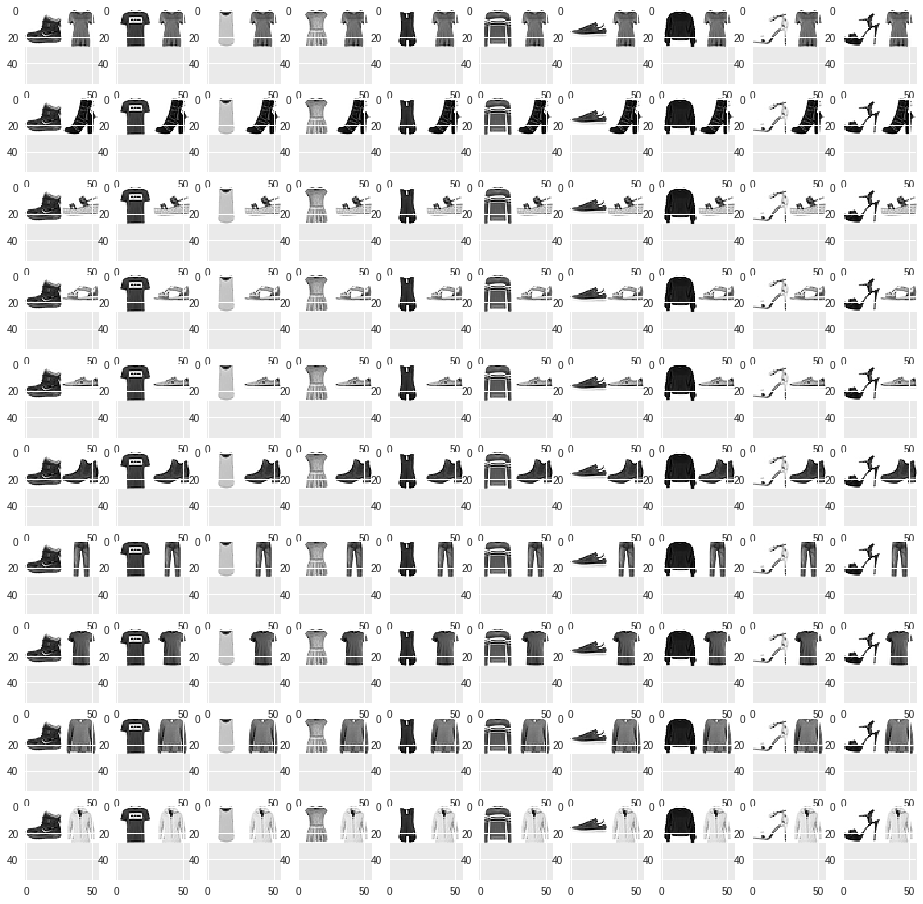

(60000, 28, 28)
(10000, 56, 56)


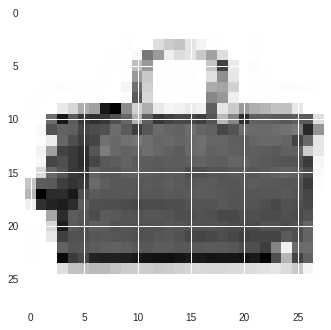

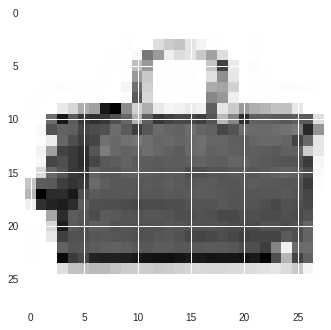

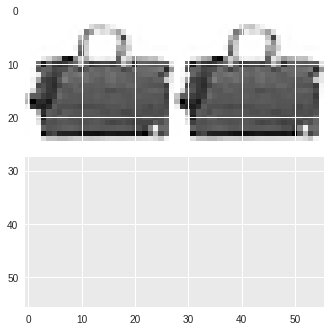

In [205]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator1, generator2, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator1.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator1, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def build_modelsNEW():
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
  ##  models = [generator1, generator2]
    models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    
    return generator1, generator2, discriminator, combined ,  

In [0]:
def main():
    generator1, generator2, discriminator, combined = build_modelsNEW()

    train(generator1, generator2,  discriminator, combined, 
          epochs=1, batch_size=32, save_interval=1)
    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_20 (ZeroPaddi (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1875 [D loss: 0.815115, acc.: 53.12%] [G loss: 0.545412]


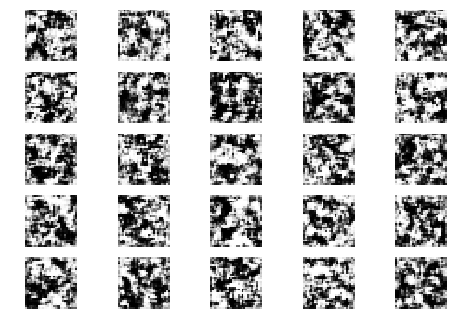

Epoch 0 Batch 1/1875 [D loss: 0.703930, acc.: 59.38%] [G loss: 0.664932]
Epoch 0 Batch 2/1875 [D loss: 0.465584, acc.: 71.88%] [G loss: 0.901918]
Epoch 0 Batch 3/1875 [D loss: 0.494156, acc.: 71.88%] [G loss: 1.023120]
Epoch 0 Batch 4/1875 [D loss: 0.422162, acc.: 78.12%] [G loss: 1.244603]
Epoch 0 Batch 5/1875 [D loss: 0.327065, acc.: 93.75%] [G loss: 1.170538]
Epoch 0 Batch 6/1875 [D loss: 0.255370, acc.: 93.75%] [G loss: 1.459968]
Epoch 0 Batch 7/1875 [D loss: 0.278949, acc.: 93.75%] [G loss: 1.507448]
Epoch 0 Batch 8/1875 [D loss: 0.256047, acc.: 93.75%] [G loss: 1.662293]
Epoch 0 Batch 9/1875 [D loss: 0.410765, acc.: 78.12%] [G loss: 2.286195]
Epoch 0 Batch 10/1875 [D loss: 0.245585, acc.: 93.75%] [G loss: 1.904598]
Epoch 0 Batch 11/1875 [D loss: 0.243664, acc.: 96.88%] [G loss: 1.931879]
Epoch 0 Batch 12/1875 [D loss: 0.244986, acc.: 90.62%] [G loss: 1.829885]
Epoch 0 Batch 13/1875 [D loss: 0.228088, acc.: 93.75%] [G loss: 2.217384]
Epoch 0 Batch 14/1875 [D loss: 0.234972, acc.: 

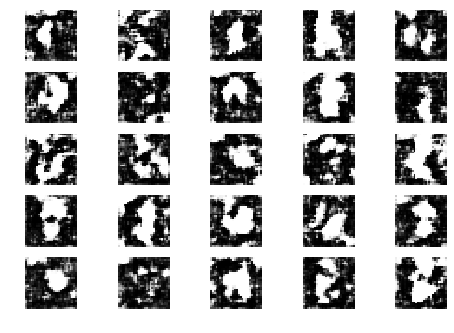

Epoch 0 Batch 51/1875 [D loss: 0.126320, acc.: 100.00%] [G loss: 3.771940]
Epoch 0 Batch 52/1875 [D loss: 0.084962, acc.: 100.00%] [G loss: 2.656591]
Epoch 0 Batch 53/1875 [D loss: 0.045616, acc.: 100.00%] [G loss: 2.768796]
Epoch 0 Batch 54/1875 [D loss: 0.118993, acc.: 96.88%] [G loss: 1.990625]
Epoch 0 Batch 55/1875 [D loss: 0.197963, acc.: 90.62%] [G loss: 3.356716]
Epoch 0 Batch 56/1875 [D loss: 0.035661, acc.: 100.00%] [G loss: 3.366938]
Epoch 0 Batch 57/1875 [D loss: 0.100523, acc.: 100.00%] [G loss: 2.114802]
Epoch 0 Batch 58/1875 [D loss: 0.098519, acc.: 93.75%] [G loss: 2.712581]
Epoch 0 Batch 59/1875 [D loss: 0.139669, acc.: 100.00%] [G loss: 2.922782]
Epoch 0 Batch 60/1875 [D loss: 0.049238, acc.: 100.00%] [G loss: 4.133864]
Epoch 0 Batch 61/1875 [D loss: 0.045443, acc.: 100.00%] [G loss: 4.048817]
Epoch 0 Batch 62/1875 [D loss: 0.566154, acc.: 62.50%] [G loss: 2.770778]
Epoch 0 Batch 63/1875 [D loss: 0.016986, acc.: 100.00%] [G loss: 4.968179]
Epoch 0 Batch 64/1875 [D loss

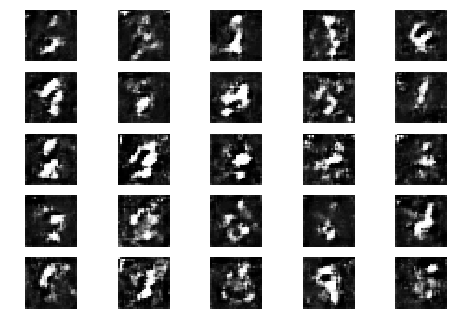

Epoch 0 Batch 101/1875 [D loss: 0.884904, acc.: 46.88%] [G loss: 2.081243]
Epoch 0 Batch 102/1875 [D loss: 0.814327, acc.: 62.50%] [G loss: 2.053477]
Epoch 0 Batch 103/1875 [D loss: 0.771510, acc.: 50.00%] [G loss: 1.656887]
Epoch 0 Batch 104/1875 [D loss: 0.707468, acc.: 59.38%] [G loss: 2.093817]
Epoch 0 Batch 105/1875 [D loss: 0.902286, acc.: 40.62%] [G loss: 1.250202]
Epoch 0 Batch 106/1875 [D loss: 0.551919, acc.: 78.12%] [G loss: 1.503815]
Epoch 0 Batch 107/1875 [D loss: 0.948343, acc.: 46.88%] [G loss: 1.357739]
Epoch 0 Batch 108/1875 [D loss: 1.267468, acc.: 43.75%] [G loss: 1.584707]
Epoch 0 Batch 109/1875 [D loss: 0.726727, acc.: 50.00%] [G loss: 2.419232]
Epoch 0 Batch 110/1875 [D loss: 0.982039, acc.: 46.88%] [G loss: 1.577057]
Epoch 0 Batch 111/1875 [D loss: 1.238695, acc.: 34.38%] [G loss: 1.345719]
Epoch 0 Batch 112/1875 [D loss: 0.766887, acc.: 59.38%] [G loss: 1.767293]
Epoch 0 Batch 113/1875 [D loss: 0.836970, acc.: 46.88%] [G loss: 1.583130]
Epoch 0 Batch 114/1875 [D

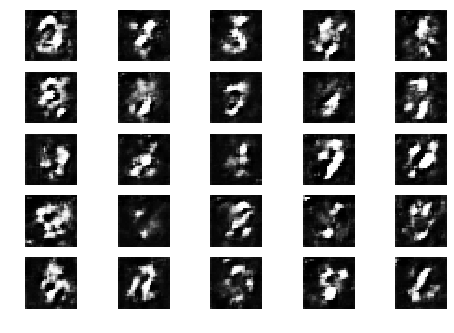

Epoch 0 Batch 151/1875 [D loss: 0.892310, acc.: 56.25%] [G loss: 1.396608]
Epoch 0 Batch 152/1875 [D loss: 0.850744, acc.: 50.00%] [G loss: 1.571908]
Epoch 0 Batch 153/1875 [D loss: 0.811401, acc.: 53.12%] [G loss: 1.442368]
Epoch 0 Batch 154/1875 [D loss: 0.713739, acc.: 56.25%] [G loss: 1.484462]
Epoch 0 Batch 155/1875 [D loss: 0.853270, acc.: 50.00%] [G loss: 1.502663]
Epoch 0 Batch 156/1875 [D loss: 0.824556, acc.: 59.38%] [G loss: 1.476499]
Epoch 0 Batch 157/1875 [D loss: 0.722747, acc.: 59.38%] [G loss: 1.675157]
Epoch 0 Batch 158/1875 [D loss: 0.956746, acc.: 37.50%] [G loss: 1.882252]
Epoch 0 Batch 159/1875 [D loss: 0.569560, acc.: 71.88%] [G loss: 1.689663]
Epoch 0 Batch 160/1875 [D loss: 0.864835, acc.: 59.38%] [G loss: 1.679845]
Epoch 0 Batch 161/1875 [D loss: 0.676503, acc.: 53.12%] [G loss: 1.168811]
Epoch 0 Batch 162/1875 [D loss: 0.664179, acc.: 53.12%] [G loss: 1.455738]
Epoch 0 Batch 163/1875 [D loss: 0.554568, acc.: 78.12%] [G loss: 1.317727]
Epoch 0 Batch 164/1875 [D

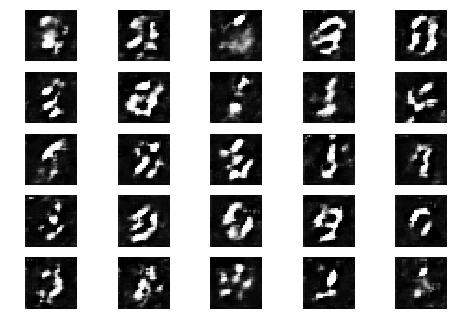

Epoch 0 Batch 201/1875 [D loss: 0.910411, acc.: 46.88%] [G loss: 1.817327]
Epoch 0 Batch 202/1875 [D loss: 0.984063, acc.: 50.00%] [G loss: 0.950059]
Epoch 0 Batch 203/1875 [D loss: 0.879750, acc.: 50.00%] [G loss: 1.024248]
Epoch 0 Batch 204/1875 [D loss: 0.713848, acc.: 65.62%] [G loss: 1.445475]
Epoch 0 Batch 205/1875 [D loss: 0.758752, acc.: 53.12%] [G loss: 1.399003]
Epoch 0 Batch 206/1875 [D loss: 0.790836, acc.: 59.38%] [G loss: 1.173291]
Epoch 0 Batch 207/1875 [D loss: 1.005077, acc.: 34.38%] [G loss: 1.339771]
Epoch 0 Batch 208/1875 [D loss: 0.805698, acc.: 50.00%] [G loss: 1.220133]
Epoch 0 Batch 209/1875 [D loss: 0.678786, acc.: 53.12%] [G loss: 0.997653]
Epoch 0 Batch 210/1875 [D loss: 0.665808, acc.: 53.12%] [G loss: 1.185350]
Epoch 0 Batch 211/1875 [D loss: 0.818541, acc.: 50.00%] [G loss: 1.593533]
Epoch 0 Batch 212/1875 [D loss: 0.646447, acc.: 62.50%] [G loss: 1.519109]
Epoch 0 Batch 213/1875 [D loss: 0.802157, acc.: 53.12%] [G loss: 1.462866]
Epoch 0 Batch 214/1875 [D

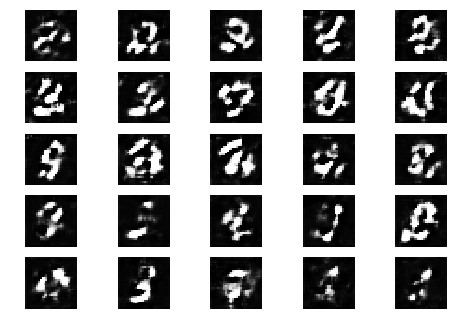

Epoch 0 Batch 251/1875 [D loss: 1.094468, acc.: 31.25%] [G loss: 0.913747]
Epoch 0 Batch 252/1875 [D loss: 0.831799, acc.: 56.25%] [G loss: 1.353592]
Epoch 0 Batch 253/1875 [D loss: 0.854225, acc.: 43.75%] [G loss: 1.299560]
Epoch 0 Batch 254/1875 [D loss: 0.793757, acc.: 53.12%] [G loss: 1.389738]
Epoch 0 Batch 255/1875 [D loss: 0.954822, acc.: 46.88%] [G loss: 1.237599]
Epoch 0 Batch 256/1875 [D loss: 0.688825, acc.: 46.88%] [G loss: 0.813591]
Epoch 0 Batch 257/1875 [D loss: 0.702992, acc.: 62.50%] [G loss: 0.914394]
Epoch 0 Batch 258/1875 [D loss: 0.782409, acc.: 50.00%] [G loss: 0.885207]
Epoch 0 Batch 259/1875 [D loss: 0.687399, acc.: 56.25%] [G loss: 1.176803]
Epoch 0 Batch 260/1875 [D loss: 0.813257, acc.: 50.00%] [G loss: 0.841074]
Epoch 0 Batch 261/1875 [D loss: 0.691476, acc.: 62.50%] [G loss: 0.975109]
Epoch 0 Batch 262/1875 [D loss: 0.629886, acc.: 68.75%] [G loss: 1.134601]
Epoch 0 Batch 263/1875 [D loss: 0.754442, acc.: 37.50%] [G loss: 1.105618]
Epoch 0 Batch 264/1875 [D

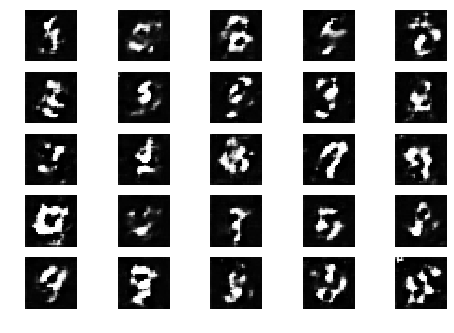

Epoch 0 Batch 301/1875 [D loss: 0.825627, acc.: 46.88%] [G loss: 1.323034]
Epoch 0 Batch 302/1875 [D loss: 0.777191, acc.: 50.00%] [G loss: 1.199478]
Epoch 0 Batch 303/1875 [D loss: 0.835920, acc.: 50.00%] [G loss: 1.175734]
Epoch 0 Batch 304/1875 [D loss: 0.636179, acc.: 62.50%] [G loss: 1.298150]
Epoch 0 Batch 305/1875 [D loss: 0.620765, acc.: 68.75%] [G loss: 1.127557]
Epoch 0 Batch 306/1875 [D loss: 0.616076, acc.: 62.50%] [G loss: 1.089024]
Epoch 0 Batch 307/1875 [D loss: 0.635776, acc.: 62.50%] [G loss: 1.225963]
Epoch 0 Batch 308/1875 [D loss: 0.557705, acc.: 71.88%] [G loss: 1.567045]
Epoch 0 Batch 309/1875 [D loss: 0.772933, acc.: 46.88%] [G loss: 1.470392]
Epoch 0 Batch 310/1875 [D loss: 0.743321, acc.: 56.25%] [G loss: 1.314206]
Epoch 0 Batch 311/1875 [D loss: 0.868135, acc.: 53.12%] [G loss: 1.373203]
Epoch 0 Batch 312/1875 [D loss: 0.770865, acc.: 56.25%] [G loss: 1.490544]
Epoch 0 Batch 313/1875 [D loss: 0.652883, acc.: 59.38%] [G loss: 1.359933]
Epoch 0 Batch 314/1875 [D

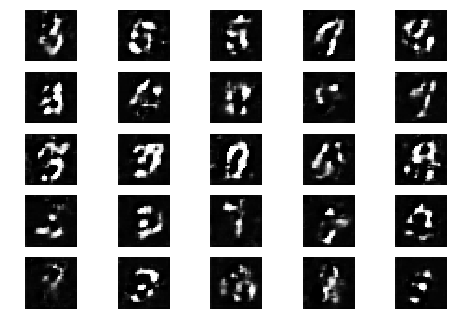

Epoch 0 Batch 351/1875 [D loss: 0.793400, acc.: 50.00%] [G loss: 1.196763]
Epoch 0 Batch 352/1875 [D loss: 0.808653, acc.: 50.00%] [G loss: 1.191071]
Epoch 0 Batch 353/1875 [D loss: 1.046793, acc.: 25.00%] [G loss: 1.515133]
Epoch 0 Batch 354/1875 [D loss: 0.580231, acc.: 71.88%] [G loss: 1.184227]
Epoch 0 Batch 355/1875 [D loss: 0.667963, acc.: 62.50%] [G loss: 1.312278]
Epoch 0 Batch 356/1875 [D loss: 0.684455, acc.: 56.25%] [G loss: 1.204465]
Epoch 0 Batch 357/1875 [D loss: 0.846442, acc.: 43.75%] [G loss: 1.331244]
Epoch 0 Batch 358/1875 [D loss: 0.664730, acc.: 65.62%] [G loss: 1.154175]
Epoch 0 Batch 359/1875 [D loss: 0.680455, acc.: 53.12%] [G loss: 1.252213]
Epoch 0 Batch 360/1875 [D loss: 0.794807, acc.: 62.50%] [G loss: 1.101836]
Epoch 0 Batch 361/1875 [D loss: 0.878240, acc.: 46.88%] [G loss: 1.334157]
Epoch 0 Batch 362/1875 [D loss: 0.787786, acc.: 59.38%] [G loss: 1.458891]
Epoch 0 Batch 363/1875 [D loss: 0.816994, acc.: 37.50%] [G loss: 1.115303]
Epoch 0 Batch 364/1875 [D

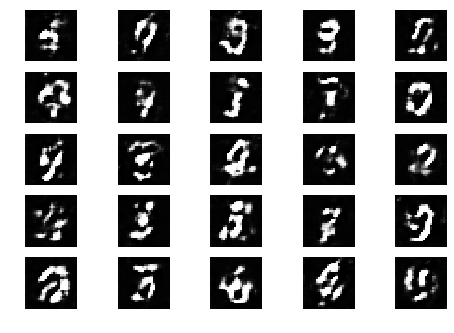

Epoch 0 Batch 401/1875 [D loss: 0.662775, acc.: 65.62%] [G loss: 1.352671]
Epoch 0 Batch 402/1875 [D loss: 0.652251, acc.: 68.75%] [G loss: 1.342936]
Epoch 0 Batch 403/1875 [D loss: 0.858892, acc.: 43.75%] [G loss: 1.139044]
Epoch 0 Batch 404/1875 [D loss: 0.769684, acc.: 59.38%] [G loss: 1.076857]
Epoch 0 Batch 405/1875 [D loss: 0.645064, acc.: 59.38%] [G loss: 1.071796]
Epoch 0 Batch 406/1875 [D loss: 0.712577, acc.: 71.88%] [G loss: 1.096732]
Epoch 0 Batch 407/1875 [D loss: 0.726058, acc.: 53.12%] [G loss: 1.150071]
Epoch 0 Batch 408/1875 [D loss: 0.710250, acc.: 50.00%] [G loss: 1.140417]
Epoch 0 Batch 409/1875 [D loss: 0.579079, acc.: 68.75%] [G loss: 0.916898]
Epoch 0 Batch 410/1875 [D loss: 0.700581, acc.: 56.25%] [G loss: 1.083880]
Epoch 0 Batch 411/1875 [D loss: 0.879708, acc.: 37.50%] [G loss: 1.072698]
Epoch 0 Batch 412/1875 [D loss: 0.495120, acc.: 75.00%] [G loss: 0.873566]
Epoch 0 Batch 413/1875 [D loss: 0.635120, acc.: 68.75%] [G loss: 1.233469]
Epoch 0 Batch 414/1875 [D

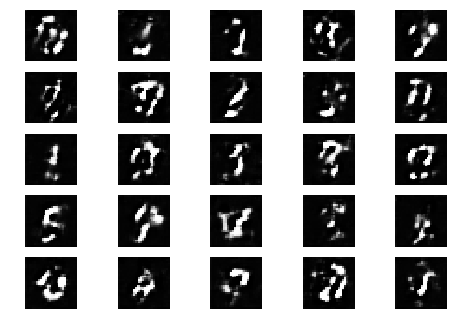

Epoch 0 Batch 451/1875 [D loss: 0.893794, acc.: 50.00%] [G loss: 1.094469]
Epoch 0 Batch 452/1875 [D loss: 0.617126, acc.: 68.75%] [G loss: 1.298078]
Epoch 0 Batch 453/1875 [D loss: 0.768346, acc.: 53.12%] [G loss: 1.204743]
Epoch 0 Batch 454/1875 [D loss: 0.736654, acc.: 59.38%] [G loss: 1.164611]
Epoch 0 Batch 455/1875 [D loss: 0.705571, acc.: 56.25%] [G loss: 1.001311]
Epoch 0 Batch 456/1875 [D loss: 0.871064, acc.: 37.50%] [G loss: 1.187712]
Epoch 0 Batch 457/1875 [D loss: 0.704047, acc.: 56.25%] [G loss: 1.148362]
Epoch 0 Batch 458/1875 [D loss: 0.837173, acc.: 40.62%] [G loss: 1.246826]
Epoch 0 Batch 459/1875 [D loss: 0.567120, acc.: 65.62%] [G loss: 1.084228]
Epoch 0 Batch 460/1875 [D loss: 0.691396, acc.: 59.38%] [G loss: 1.396905]
Epoch 0 Batch 461/1875 [D loss: 0.853915, acc.: 40.62%] [G loss: 1.349095]
Epoch 0 Batch 462/1875 [D loss: 0.706597, acc.: 62.50%] [G loss: 1.190926]
Epoch 0 Batch 463/1875 [D loss: 0.714496, acc.: 56.25%] [G loss: 1.235863]
Epoch 0 Batch 464/1875 [D

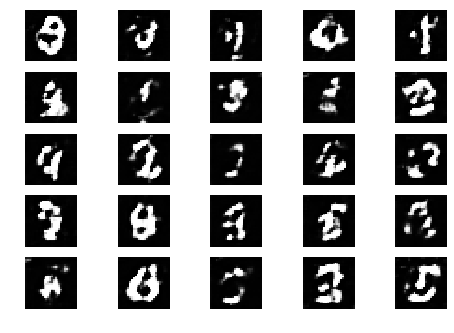

Epoch 0 Batch 501/1875 [D loss: 0.711888, acc.: 56.25%] [G loss: 0.914767]
Epoch 0 Batch 502/1875 [D loss: 0.755116, acc.: 50.00%] [G loss: 1.034750]
Epoch 0 Batch 503/1875 [D loss: 0.566031, acc.: 62.50%] [G loss: 1.215079]
Epoch 0 Batch 504/1875 [D loss: 0.625227, acc.: 68.75%] [G loss: 1.262780]
Epoch 0 Batch 505/1875 [D loss: 0.769803, acc.: 46.88%] [G loss: 1.373572]
Epoch 0 Batch 506/1875 [D loss: 0.846036, acc.: 37.50%] [G loss: 1.340875]
Epoch 0 Batch 507/1875 [D loss: 0.943177, acc.: 31.25%] [G loss: 1.228486]
Epoch 0 Batch 508/1875 [D loss: 0.828010, acc.: 43.75%] [G loss: 1.320498]
Epoch 0 Batch 509/1875 [D loss: 0.636347, acc.: 59.38%] [G loss: 1.022184]
Epoch 0 Batch 510/1875 [D loss: 0.662861, acc.: 71.88%] [G loss: 1.036283]
Epoch 0 Batch 511/1875 [D loss: 0.594323, acc.: 71.88%] [G loss: 1.246648]
Epoch 0 Batch 512/1875 [D loss: 0.573417, acc.: 78.12%] [G loss: 1.189717]
Epoch 0 Batch 513/1875 [D loss: 0.798687, acc.: 50.00%] [G loss: 0.958815]
Epoch 0 Batch 514/1875 [D

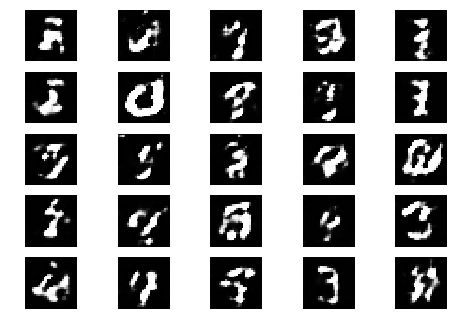

Epoch 0 Batch 551/1875 [D loss: 0.635255, acc.: 56.25%] [G loss: 1.181901]
Epoch 0 Batch 552/1875 [D loss: 0.812402, acc.: 59.38%] [G loss: 1.304866]
Epoch 0 Batch 553/1875 [D loss: 0.614667, acc.: 65.62%] [G loss: 1.205860]
Epoch 0 Batch 554/1875 [D loss: 0.781849, acc.: 50.00%] [G loss: 1.234857]
Epoch 0 Batch 555/1875 [D loss: 0.711520, acc.: 56.25%] [G loss: 1.233352]
Epoch 0 Batch 556/1875 [D loss: 0.654268, acc.: 65.62%] [G loss: 1.125256]
Epoch 0 Batch 557/1875 [D loss: 0.936269, acc.: 40.62%] [G loss: 1.022924]
Epoch 0 Batch 558/1875 [D loss: 0.677122, acc.: 56.25%] [G loss: 0.984397]
Epoch 0 Batch 559/1875 [D loss: 0.701046, acc.: 62.50%] [G loss: 0.969671]
Epoch 0 Batch 560/1875 [D loss: 0.726073, acc.: 53.12%] [G loss: 1.208901]
Epoch 0 Batch 561/1875 [D loss: 0.579919, acc.: 62.50%] [G loss: 1.173966]
Epoch 0 Batch 562/1875 [D loss: 0.740571, acc.: 53.12%] [G loss: 0.924624]
Epoch 0 Batch 563/1875 [D loss: 0.412882, acc.: 87.50%] [G loss: 1.050433]
Epoch 0 Batch 564/1875 [D

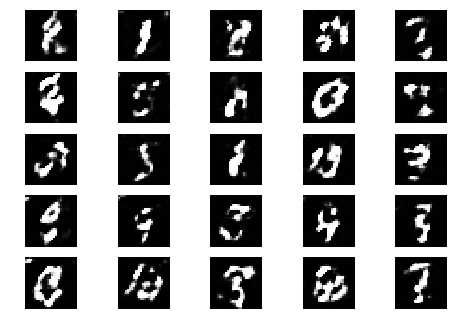

Epoch 0 Batch 601/1875 [D loss: 0.749564, acc.: 50.00%] [G loss: 1.151873]
Epoch 0 Batch 602/1875 [D loss: 0.593370, acc.: 56.25%] [G loss: 1.363544]
Epoch 0 Batch 603/1875 [D loss: 0.731847, acc.: 53.12%] [G loss: 1.247696]
Epoch 0 Batch 604/1875 [D loss: 0.680124, acc.: 56.25%] [G loss: 1.209945]
Epoch 0 Batch 605/1875 [D loss: 0.481670, acc.: 81.25%] [G loss: 1.292355]
Epoch 0 Batch 606/1875 [D loss: 0.517458, acc.: 78.12%] [G loss: 1.187435]
Epoch 0 Batch 607/1875 [D loss: 0.828597, acc.: 46.88%] [G loss: 1.235782]
Epoch 0 Batch 608/1875 [D loss: 0.753513, acc.: 62.50%] [G loss: 1.524633]
Epoch 0 Batch 609/1875 [D loss: 0.550157, acc.: 65.62%] [G loss: 1.302730]
Epoch 0 Batch 610/1875 [D loss: 0.713410, acc.: 62.50%] [G loss: 1.216460]
Epoch 0 Batch 611/1875 [D loss: 0.748361, acc.: 53.12%] [G loss: 1.213650]
Epoch 0 Batch 612/1875 [D loss: 0.758385, acc.: 59.38%] [G loss: 1.175260]
Epoch 0 Batch 613/1875 [D loss: 0.690920, acc.: 46.88%] [G loss: 1.299333]
Epoch 0 Batch 614/1875 [D

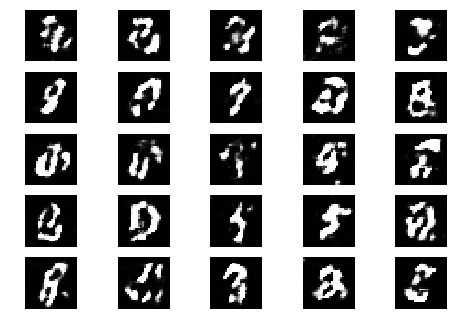

Epoch 0 Batch 651/1875 [D loss: 0.681212, acc.: 65.62%] [G loss: 1.036007]
Epoch 0 Batch 652/1875 [D loss: 0.573098, acc.: 65.62%] [G loss: 1.238353]
Epoch 0 Batch 653/1875 [D loss: 0.854369, acc.: 53.12%] [G loss: 1.131272]
Epoch 0 Batch 654/1875 [D loss: 0.466473, acc.: 81.25%] [G loss: 1.252809]
Epoch 0 Batch 655/1875 [D loss: 0.883384, acc.: 53.12%] [G loss: 1.330497]
Epoch 0 Batch 656/1875 [D loss: 0.651641, acc.: 68.75%] [G loss: 1.297275]
Epoch 0 Batch 657/1875 [D loss: 0.661494, acc.: 68.75%] [G loss: 1.192350]
Epoch 0 Batch 658/1875 [D loss: 0.661335, acc.: 65.62%] [G loss: 0.893286]
Epoch 0 Batch 659/1875 [D loss: 0.645814, acc.: 62.50%] [G loss: 1.129176]
Epoch 0 Batch 660/1875 [D loss: 0.782847, acc.: 50.00%] [G loss: 1.121249]
Epoch 0 Batch 661/1875 [D loss: 0.654197, acc.: 68.75%] [G loss: 1.138981]
Epoch 0 Batch 662/1875 [D loss: 0.642674, acc.: 56.25%] [G loss: 1.483500]
Epoch 0 Batch 663/1875 [D loss: 0.619555, acc.: 78.12%] [G loss: 1.484202]
Epoch 0 Batch 664/1875 [D

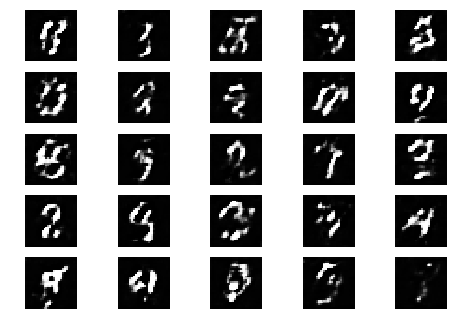

Epoch 0 Batch 701/1875 [D loss: 0.639863, acc.: 65.62%] [G loss: 0.815618]
Epoch 0 Batch 702/1875 [D loss: 0.625157, acc.: 68.75%] [G loss: 0.794677]
Epoch 0 Batch 703/1875 [D loss: 0.652808, acc.: 62.50%] [G loss: 1.211932]
Epoch 0 Batch 704/1875 [D loss: 0.815221, acc.: 46.88%] [G loss: 1.018740]
Epoch 0 Batch 705/1875 [D loss: 0.610834, acc.: 71.88%] [G loss: 1.160689]
Epoch 0 Batch 706/1875 [D loss: 0.539562, acc.: 65.62%] [G loss: 1.582764]
Epoch 0 Batch 707/1875 [D loss: 0.418987, acc.: 87.50%] [G loss: 1.362030]
Epoch 0 Batch 708/1875 [D loss: 0.665619, acc.: 68.75%] [G loss: 1.046752]
Epoch 0 Batch 709/1875 [D loss: 0.632803, acc.: 59.38%] [G loss: 1.220937]
Epoch 0 Batch 710/1875 [D loss: 0.686393, acc.: 65.62%] [G loss: 1.027989]
Epoch 0 Batch 711/1875 [D loss: 0.508774, acc.: 87.50%] [G loss: 1.350397]
Epoch 0 Batch 712/1875 [D loss: 0.644907, acc.: 65.62%] [G loss: 1.460701]
Epoch 0 Batch 713/1875 [D loss: 0.434305, acc.: 84.38%] [G loss: 1.383373]
Epoch 0 Batch 714/1875 [D

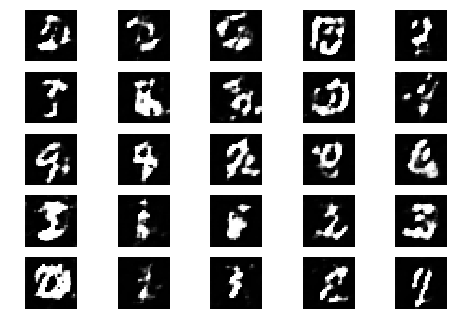

Epoch 0 Batch 751/1875 [D loss: 0.676055, acc.: 62.50%] [G loss: 1.443862]
Epoch 0 Batch 752/1875 [D loss: 0.553584, acc.: 78.12%] [G loss: 1.494317]
Epoch 0 Batch 753/1875 [D loss: 0.527487, acc.: 71.88%] [G loss: 1.248075]
Epoch 0 Batch 754/1875 [D loss: 0.696505, acc.: 62.50%] [G loss: 1.060672]
Epoch 0 Batch 755/1875 [D loss: 0.582156, acc.: 68.75%] [G loss: 1.228836]
Epoch 0 Batch 756/1875 [D loss: 0.749922, acc.: 56.25%] [G loss: 1.417447]
Epoch 0 Batch 757/1875 [D loss: 0.753264, acc.: 50.00%] [G loss: 1.321280]
Epoch 0 Batch 758/1875 [D loss: 0.564387, acc.: 71.88%] [G loss: 1.220112]
Epoch 0 Batch 759/1875 [D loss: 0.567165, acc.: 65.62%] [G loss: 1.143311]
Epoch 0 Batch 760/1875 [D loss: 0.506611, acc.: 71.88%] [G loss: 1.144509]
Epoch 0 Batch 761/1875 [D loss: 0.578171, acc.: 62.50%] [G loss: 1.102905]
Epoch 0 Batch 762/1875 [D loss: 0.734792, acc.: 56.25%] [G loss: 1.159737]
Epoch 0 Batch 763/1875 [D loss: 0.465019, acc.: 81.25%] [G loss: 1.417147]
Epoch 0 Batch 764/1875 [D

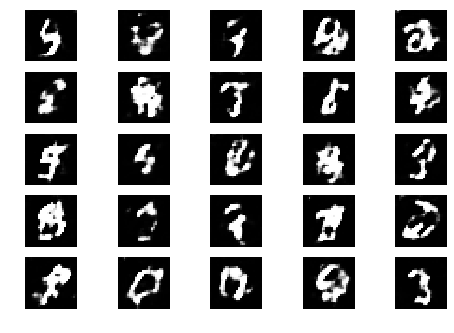

Epoch 0 Batch 801/1875 [D loss: 0.519441, acc.: 78.12%] [G loss: 1.158284]
Epoch 0 Batch 802/1875 [D loss: 0.619689, acc.: 65.62%] [G loss: 1.090071]
Epoch 0 Batch 803/1875 [D loss: 0.538446, acc.: 75.00%] [G loss: 1.183617]
Epoch 0 Batch 804/1875 [D loss: 0.642576, acc.: 59.38%] [G loss: 1.157527]
Epoch 0 Batch 805/1875 [D loss: 0.538038, acc.: 75.00%] [G loss: 1.180005]
Epoch 0 Batch 806/1875 [D loss: 0.490712, acc.: 78.12%] [G loss: 1.174325]
Epoch 0 Batch 807/1875 [D loss: 0.472245, acc.: 81.25%] [G loss: 1.345999]
Epoch 0 Batch 808/1875 [D loss: 0.716580, acc.: 68.75%] [G loss: 0.871900]
Epoch 0 Batch 809/1875 [D loss: 0.672890, acc.: 62.50%] [G loss: 0.878710]
Epoch 0 Batch 810/1875 [D loss: 0.634569, acc.: 56.25%] [G loss: 1.226094]
Epoch 0 Batch 811/1875 [D loss: 0.536784, acc.: 68.75%] [G loss: 1.306020]
Epoch 0 Batch 812/1875 [D loss: 0.633537, acc.: 62.50%] [G loss: 1.141297]
Epoch 0 Batch 813/1875 [D loss: 0.507635, acc.: 78.12%] [G loss: 1.213764]
Epoch 0 Batch 814/1875 [D

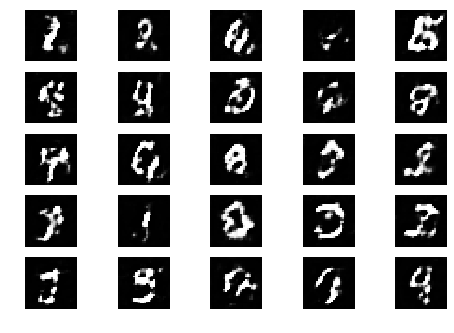

Epoch 0 Batch 851/1875 [D loss: 0.637992, acc.: 65.62%] [G loss: 1.035881]
Epoch 0 Batch 852/1875 [D loss: 0.700617, acc.: 65.62%] [G loss: 1.025626]
Epoch 0 Batch 853/1875 [D loss: 0.516692, acc.: 75.00%] [G loss: 1.158026]
Epoch 0 Batch 854/1875 [D loss: 0.663063, acc.: 65.62%] [G loss: 1.189078]
Epoch 0 Batch 855/1875 [D loss: 0.551287, acc.: 71.88%] [G loss: 1.022408]
Epoch 0 Batch 856/1875 [D loss: 0.505247, acc.: 78.12%] [G loss: 1.217283]
Epoch 0 Batch 857/1875 [D loss: 0.518923, acc.: 68.75%] [G loss: 1.134790]
Epoch 0 Batch 858/1875 [D loss: 0.642201, acc.: 53.12%] [G loss: 1.337858]
Epoch 0 Batch 859/1875 [D loss: 0.685804, acc.: 50.00%] [G loss: 1.205860]
Epoch 0 Batch 860/1875 [D loss: 0.575797, acc.: 75.00%] [G loss: 1.116745]
Epoch 0 Batch 861/1875 [D loss: 0.727588, acc.: 62.50%] [G loss: 1.169479]
Epoch 0 Batch 862/1875 [D loss: 0.521237, acc.: 75.00%] [G loss: 1.375064]
Epoch 0 Batch 863/1875 [D loss: 0.838278, acc.: 40.62%] [G loss: 1.073426]
Epoch 0 Batch 864/1875 [D

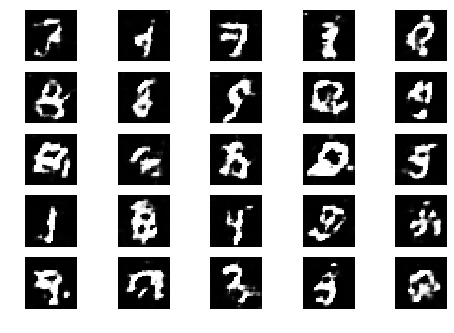

Epoch 0 Batch 901/1875 [D loss: 0.737576, acc.: 53.12%] [G loss: 1.151138]
Epoch 0 Batch 902/1875 [D loss: 0.562832, acc.: 75.00%] [G loss: 1.350442]
Epoch 0 Batch 903/1875 [D loss: 0.744971, acc.: 56.25%] [G loss: 1.201338]
Epoch 0 Batch 904/1875 [D loss: 0.542947, acc.: 71.88%] [G loss: 1.538115]
Epoch 0 Batch 905/1875 [D loss: 0.528834, acc.: 65.62%] [G loss: 1.163198]
Epoch 0 Batch 906/1875 [D loss: 0.490426, acc.: 75.00%] [G loss: 1.528798]
Epoch 0 Batch 907/1875 [D loss: 0.688992, acc.: 56.25%] [G loss: 1.133928]
Epoch 0 Batch 908/1875 [D loss: 0.515824, acc.: 75.00%] [G loss: 1.012380]
Epoch 0 Batch 909/1875 [D loss: 0.803623, acc.: 50.00%] [G loss: 0.857643]
Epoch 0 Batch 910/1875 [D loss: 0.626625, acc.: 59.38%] [G loss: 1.103948]
Epoch 0 Batch 911/1875 [D loss: 0.545951, acc.: 71.88%] [G loss: 1.186524]
Epoch 0 Batch 912/1875 [D loss: 0.669525, acc.: 71.88%] [G loss: 1.201632]
Epoch 0 Batch 913/1875 [D loss: 0.586967, acc.: 71.88%] [G loss: 1.116456]
Epoch 0 Batch 914/1875 [D

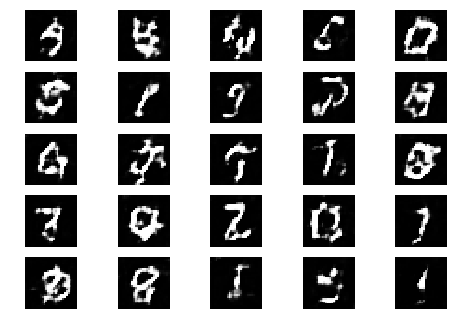

Epoch 0 Batch 951/1875 [D loss: 0.760471, acc.: 56.25%] [G loss: 1.232943]
Epoch 0 Batch 952/1875 [D loss: 0.794739, acc.: 50.00%] [G loss: 0.867367]
Epoch 0 Batch 953/1875 [D loss: 0.679199, acc.: 59.38%] [G loss: 1.067023]
Epoch 0 Batch 954/1875 [D loss: 0.665493, acc.: 62.50%] [G loss: 0.918880]
Epoch 0 Batch 955/1875 [D loss: 0.586569, acc.: 71.88%] [G loss: 1.167489]
Epoch 0 Batch 956/1875 [D loss: 0.628562, acc.: 65.62%] [G loss: 0.873246]
Epoch 0 Batch 957/1875 [D loss: 0.676024, acc.: 59.38%] [G loss: 1.111461]
Epoch 0 Batch 958/1875 [D loss: 0.505200, acc.: 78.12%] [G loss: 1.513177]
Epoch 0 Batch 959/1875 [D loss: 0.654732, acc.: 56.25%] [G loss: 1.185425]
Epoch 0 Batch 960/1875 [D loss: 0.631704, acc.: 62.50%] [G loss: 0.937170]
Epoch 0 Batch 961/1875 [D loss: 0.749101, acc.: 53.12%] [G loss: 0.953962]
Epoch 0 Batch 962/1875 [D loss: 0.486680, acc.: 81.25%] [G loss: 0.888372]
Epoch 0 Batch 963/1875 [D loss: 0.595191, acc.: 65.62%] [G loss: 1.225251]
Epoch 0 Batch 964/1875 [D

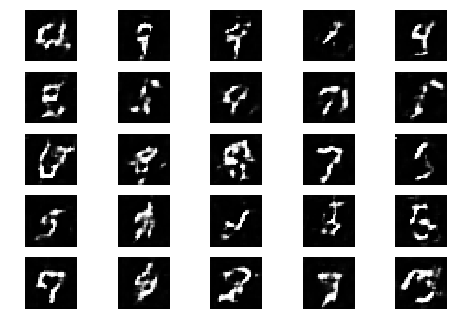

Epoch 0 Batch 1001/1875 [D loss: 0.683836, acc.: 62.50%] [G loss: 1.035038]
Epoch 0 Batch 1002/1875 [D loss: 0.815333, acc.: 50.00%] [G loss: 1.020391]
Epoch 0 Batch 1003/1875 [D loss: 0.676803, acc.: 59.38%] [G loss: 1.312485]
Epoch 0 Batch 1004/1875 [D loss: 0.694825, acc.: 59.38%] [G loss: 1.239127]
Epoch 0 Batch 1005/1875 [D loss: 0.645975, acc.: 65.62%] [G loss: 1.469058]
Epoch 0 Batch 1006/1875 [D loss: 0.651966, acc.: 62.50%] [G loss: 1.310828]
Epoch 0 Batch 1007/1875 [D loss: 0.651562, acc.: 62.50%] [G loss: 1.131740]
Epoch 0 Batch 1008/1875 [D loss: 0.626185, acc.: 78.12%] [G loss: 1.077647]
Epoch 0 Batch 1009/1875 [D loss: 0.679654, acc.: 65.62%] [G loss: 1.392606]
Epoch 0 Batch 1010/1875 [D loss: 0.613119, acc.: 62.50%] [G loss: 1.363450]
Epoch 0 Batch 1011/1875 [D loss: 0.860777, acc.: 46.88%] [G loss: 1.312995]
Epoch 0 Batch 1012/1875 [D loss: 0.746469, acc.: 50.00%] [G loss: 1.017385]
Epoch 0 Batch 1013/1875 [D loss: 0.659570, acc.: 65.62%] [G loss: 1.237479]
Epoch 0 Batc

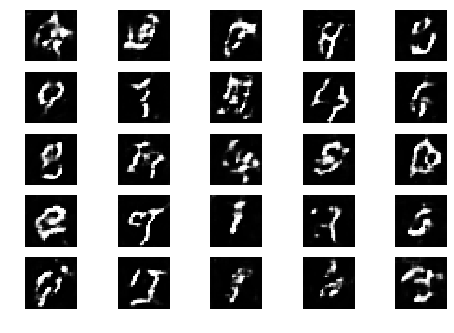

Epoch 0 Batch 1051/1875 [D loss: 0.681619, acc.: 65.62%] [G loss: 1.160814]
Epoch 0 Batch 1052/1875 [D loss: 0.680108, acc.: 59.38%] [G loss: 1.085789]
Epoch 0 Batch 1053/1875 [D loss: 0.698775, acc.: 62.50%] [G loss: 1.014783]
Epoch 0 Batch 1054/1875 [D loss: 0.789830, acc.: 56.25%] [G loss: 1.110508]
Epoch 0 Batch 1055/1875 [D loss: 0.718918, acc.: 53.12%] [G loss: 1.300167]
Epoch 0 Batch 1056/1875 [D loss: 0.561090, acc.: 68.75%] [G loss: 1.123071]
Epoch 0 Batch 1057/1875 [D loss: 0.816861, acc.: 46.88%] [G loss: 1.144475]
Epoch 0 Batch 1058/1875 [D loss: 0.772065, acc.: 46.88%] [G loss: 1.324341]
Epoch 0 Batch 1059/1875 [D loss: 0.623619, acc.: 62.50%] [G loss: 1.493963]
Epoch 0 Batch 1060/1875 [D loss: 0.598910, acc.: 68.75%] [G loss: 1.258671]
Epoch 0 Batch 1061/1875 [D loss: 0.483679, acc.: 81.25%] [G loss: 1.320207]
Epoch 0 Batch 1062/1875 [D loss: 0.640292, acc.: 62.50%] [G loss: 1.285707]
Epoch 0 Batch 1063/1875 [D loss: 0.617065, acc.: 65.62%] [G loss: 1.306666]
Epoch 0 Batc

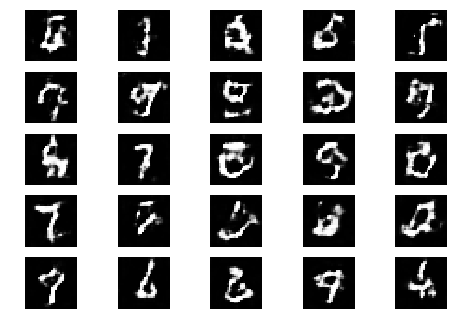

Epoch 0 Batch 1101/1875 [D loss: 0.643693, acc.: 65.62%] [G loss: 0.991350]
Epoch 0 Batch 1102/1875 [D loss: 0.782741, acc.: 50.00%] [G loss: 1.052333]
Epoch 0 Batch 1103/1875 [D loss: 0.704879, acc.: 53.12%] [G loss: 1.287615]
Epoch 0 Batch 1104/1875 [D loss: 0.755737, acc.: 68.75%] [G loss: 1.014247]
Epoch 0 Batch 1105/1875 [D loss: 0.626395, acc.: 62.50%] [G loss: 1.496421]
Epoch 0 Batch 1106/1875 [D loss: 0.624318, acc.: 71.88%] [G loss: 1.227135]
Epoch 0 Batch 1107/1875 [D loss: 0.611390, acc.: 68.75%] [G loss: 1.335526]
Epoch 0 Batch 1108/1875 [D loss: 0.652604, acc.: 59.38%] [G loss: 1.283280]
Epoch 0 Batch 1109/1875 [D loss: 0.694427, acc.: 59.38%] [G loss: 1.381438]
Epoch 0 Batch 1110/1875 [D loss: 0.722209, acc.: 68.75%] [G loss: 1.130533]
Epoch 0 Batch 1111/1875 [D loss: 0.517366, acc.: 68.75%] [G loss: 1.026398]
Epoch 0 Batch 1112/1875 [D loss: 0.834116, acc.: 50.00%] [G loss: 1.027141]
Epoch 0 Batch 1113/1875 [D loss: 0.479819, acc.: 75.00%] [G loss: 0.918236]
Epoch 0 Batc

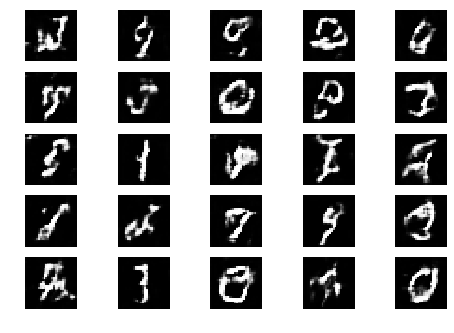

Epoch 0 Batch 1151/1875 [D loss: 0.608631, acc.: 62.50%] [G loss: 0.819027]
Epoch 0 Batch 1152/1875 [D loss: 0.701942, acc.: 56.25%] [G loss: 0.899332]
Epoch 0 Batch 1153/1875 [D loss: 0.634272, acc.: 59.38%] [G loss: 1.041950]
Epoch 0 Batch 1154/1875 [D loss: 0.587740, acc.: 75.00%] [G loss: 0.949497]
Epoch 0 Batch 1155/1875 [D loss: 0.668929, acc.: 56.25%] [G loss: 1.068406]
Epoch 0 Batch 1156/1875 [D loss: 0.606438, acc.: 71.88%] [G loss: 1.184550]
Epoch 0 Batch 1157/1875 [D loss: 0.628156, acc.: 68.75%] [G loss: 0.956861]
Epoch 0 Batch 1158/1875 [D loss: 0.843869, acc.: 46.88%] [G loss: 1.012553]
Epoch 0 Batch 1159/1875 [D loss: 0.780023, acc.: 53.12%] [G loss: 0.925315]
Epoch 0 Batch 1160/1875 [D loss: 0.611326, acc.: 65.62%] [G loss: 1.140217]
Epoch 0 Batch 1161/1875 [D loss: 0.660876, acc.: 56.25%] [G loss: 1.147890]
Epoch 0 Batch 1162/1875 [D loss: 0.516464, acc.: 78.12%] [G loss: 1.007893]
Epoch 0 Batch 1163/1875 [D loss: 0.648320, acc.: 62.50%] [G loss: 1.316508]
Epoch 0 Batc

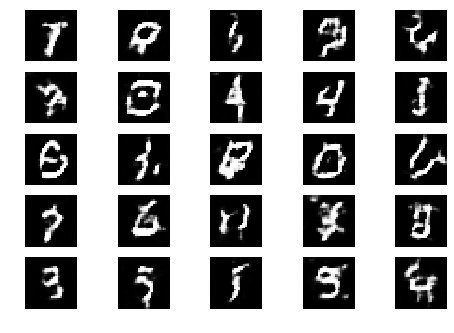

Epoch 0 Batch 1201/1875 [D loss: 0.860657, acc.: 46.88%] [G loss: 1.016972]
Epoch 0 Batch 1202/1875 [D loss: 0.727984, acc.: 59.38%] [G loss: 1.253296]
Epoch 0 Batch 1203/1875 [D loss: 0.666300, acc.: 59.38%] [G loss: 0.993107]
Epoch 0 Batch 1204/1875 [D loss: 0.729875, acc.: 50.00%] [G loss: 0.928936]
Epoch 0 Batch 1205/1875 [D loss: 0.814395, acc.: 34.38%] [G loss: 0.819749]
Epoch 0 Batch 1206/1875 [D loss: 0.635404, acc.: 56.25%] [G loss: 1.028015]
Epoch 0 Batch 1207/1875 [D loss: 0.593204, acc.: 71.88%] [G loss: 1.150027]
Epoch 0 Batch 1208/1875 [D loss: 0.873761, acc.: 37.50%] [G loss: 1.340550]
Epoch 0 Batch 1209/1875 [D loss: 0.692374, acc.: 59.38%] [G loss: 1.059356]
Epoch 0 Batch 1210/1875 [D loss: 0.723908, acc.: 53.12%] [G loss: 0.979705]
Epoch 0 Batch 1211/1875 [D loss: 0.679389, acc.: 56.25%] [G loss: 1.039859]
Epoch 0 Batch 1212/1875 [D loss: 0.745034, acc.: 65.62%] [G loss: 0.977753]
Epoch 0 Batch 1213/1875 [D loss: 0.474486, acc.: 81.25%] [G loss: 1.121440]
Epoch 0 Batc

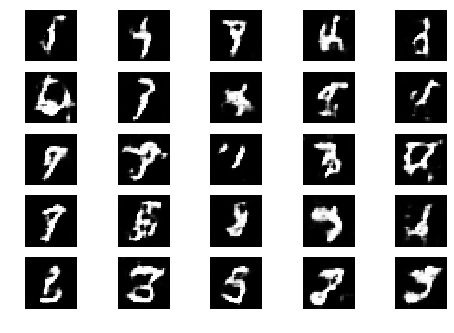

Epoch 0 Batch 1251/1875 [D loss: 0.734167, acc.: 53.12%] [G loss: 1.074398]
Epoch 0 Batch 1252/1875 [D loss: 0.666242, acc.: 65.62%] [G loss: 1.239461]
Epoch 0 Batch 1253/1875 [D loss: 0.713463, acc.: 53.12%] [G loss: 1.037468]
Epoch 0 Batch 1254/1875 [D loss: 0.555840, acc.: 65.62%] [G loss: 1.375947]
Epoch 0 Batch 1255/1875 [D loss: 0.579263, acc.: 75.00%] [G loss: 1.253899]
Epoch 0 Batch 1256/1875 [D loss: 0.546865, acc.: 78.12%] [G loss: 1.076265]
Epoch 0 Batch 1257/1875 [D loss: 0.554408, acc.: 71.88%] [G loss: 0.912503]
Epoch 0 Batch 1258/1875 [D loss: 0.673947, acc.: 59.38%] [G loss: 0.971923]
Epoch 0 Batch 1259/1875 [D loss: 0.925134, acc.: 46.88%] [G loss: 1.082784]
Epoch 0 Batch 1260/1875 [D loss: 0.585462, acc.: 62.50%] [G loss: 1.163827]
Epoch 0 Batch 1261/1875 [D loss: 0.736913, acc.: 46.88%] [G loss: 0.952237]
Epoch 0 Batch 1262/1875 [D loss: 0.702871, acc.: 59.38%] [G loss: 1.016179]
Epoch 0 Batch 1263/1875 [D loss: 0.608014, acc.: 65.62%] [G loss: 0.888418]
Epoch 0 Batc

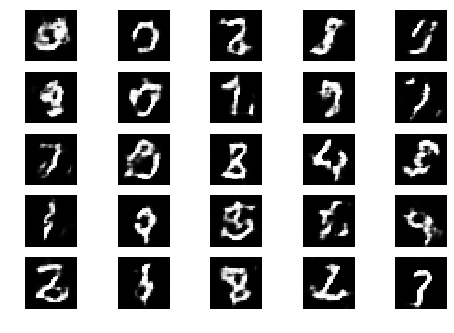

Epoch 0 Batch 1301/1875 [D loss: 0.631169, acc.: 65.62%] [G loss: 0.992257]
Epoch 0 Batch 1302/1875 [D loss: 0.639314, acc.: 59.38%] [G loss: 1.168676]
Epoch 0 Batch 1303/1875 [D loss: 0.775836, acc.: 50.00%] [G loss: 0.982740]
Epoch 0 Batch 1304/1875 [D loss: 0.690054, acc.: 62.50%] [G loss: 1.147945]
Epoch 0 Batch 1305/1875 [D loss: 0.715968, acc.: 50.00%] [G loss: 1.046592]
Epoch 0 Batch 1306/1875 [D loss: 0.633982, acc.: 62.50%] [G loss: 1.119031]
Epoch 0 Batch 1307/1875 [D loss: 0.688939, acc.: 53.12%] [G loss: 1.061082]
Epoch 0 Batch 1308/1875 [D loss: 0.627885, acc.: 65.62%] [G loss: 1.278399]
Epoch 0 Batch 1309/1875 [D loss: 0.598415, acc.: 68.75%] [G loss: 1.098843]
Epoch 0 Batch 1310/1875 [D loss: 0.620853, acc.: 62.50%] [G loss: 1.211987]
Epoch 0 Batch 1311/1875 [D loss: 0.655335, acc.: 59.38%] [G loss: 1.055957]
Epoch 0 Batch 1312/1875 [D loss: 0.749146, acc.: 50.00%] [G loss: 0.986001]
Epoch 0 Batch 1313/1875 [D loss: 0.895999, acc.: 43.75%] [G loss: 0.949292]
Epoch 0 Batc

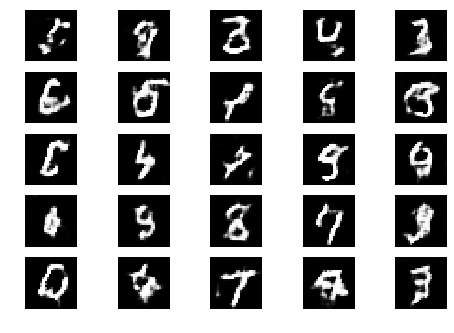

Epoch 0 Batch 1351/1875 [D loss: 0.579719, acc.: 59.38%] [G loss: 0.971395]
Epoch 0 Batch 1352/1875 [D loss: 0.668221, acc.: 56.25%] [G loss: 0.937751]
Epoch 0 Batch 1353/1875 [D loss: 0.754385, acc.: 46.88%] [G loss: 1.122326]
Epoch 0 Batch 1354/1875 [D loss: 0.585187, acc.: 65.62%] [G loss: 1.392495]
Epoch 0 Batch 1355/1875 [D loss: 0.863564, acc.: 34.38%] [G loss: 1.258435]
Epoch 0 Batch 1356/1875 [D loss: 0.660169, acc.: 68.75%] [G loss: 1.144539]
Epoch 0 Batch 1357/1875 [D loss: 0.883183, acc.: 46.88%] [G loss: 1.119577]
Epoch 0 Batch 1358/1875 [D loss: 0.755190, acc.: 56.25%] [G loss: 0.939073]
Epoch 0 Batch 1359/1875 [D loss: 0.609579, acc.: 59.38%] [G loss: 0.975428]
Epoch 0 Batch 1360/1875 [D loss: 0.672420, acc.: 56.25%] [G loss: 1.020369]
Epoch 0 Batch 1361/1875 [D loss: 0.670033, acc.: 59.38%] [G loss: 1.233121]
Epoch 0 Batch 1362/1875 [D loss: 0.834388, acc.: 43.75%] [G loss: 1.304680]
Epoch 0 Batch 1363/1875 [D loss: 0.600038, acc.: 71.88%] [G loss: 1.136091]
Epoch 0 Batc

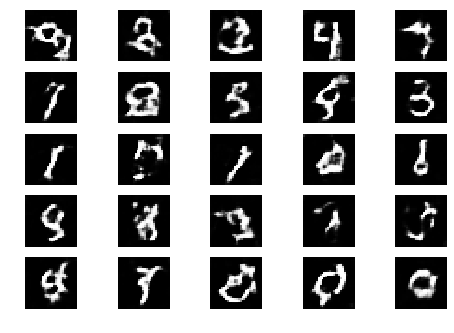

Epoch 0 Batch 1401/1875 [D loss: 0.698577, acc.: 62.50%] [G loss: 1.146801]
Epoch 0 Batch 1402/1875 [D loss: 0.747836, acc.: 62.50%] [G loss: 0.983009]
Epoch 0 Batch 1403/1875 [D loss: 0.721219, acc.: 50.00%] [G loss: 1.094488]
Epoch 0 Batch 1404/1875 [D loss: 0.446290, acc.: 81.25%] [G loss: 0.955172]
Epoch 0 Batch 1405/1875 [D loss: 0.708111, acc.: 59.38%] [G loss: 0.835483]
Epoch 0 Batch 1406/1875 [D loss: 0.675659, acc.: 65.62%] [G loss: 0.797954]
Epoch 0 Batch 1407/1875 [D loss: 0.663992, acc.: 59.38%] [G loss: 1.129589]
Epoch 0 Batch 1408/1875 [D loss: 0.706827, acc.: 56.25%] [G loss: 0.955359]
Epoch 0 Batch 1409/1875 [D loss: 0.837314, acc.: 50.00%] [G loss: 1.027466]
Epoch 0 Batch 1410/1875 [D loss: 0.758892, acc.: 56.25%] [G loss: 1.023142]
Epoch 0 Batch 1411/1875 [D loss: 0.602636, acc.: 56.25%] [G loss: 0.928105]
Epoch 0 Batch 1412/1875 [D loss: 0.867481, acc.: 46.88%] [G loss: 0.977933]
Epoch 0 Batch 1413/1875 [D loss: 0.661824, acc.: 56.25%] [G loss: 1.084911]
Epoch 0 Batc

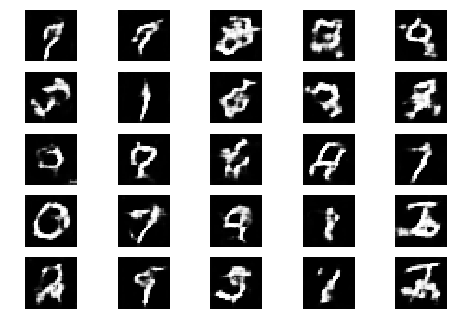

Epoch 0 Batch 1451/1875 [D loss: 0.669284, acc.: 62.50%] [G loss: 1.033182]
Epoch 0 Batch 1452/1875 [D loss: 0.701396, acc.: 65.62%] [G loss: 0.954299]
Epoch 0 Batch 1453/1875 [D loss: 0.741888, acc.: 62.50%] [G loss: 1.127371]
Epoch 0 Batch 1454/1875 [D loss: 0.659932, acc.: 65.62%] [G loss: 1.026694]
Epoch 0 Batch 1455/1875 [D loss: 0.744650, acc.: 46.88%] [G loss: 1.074231]
Epoch 0 Batch 1456/1875 [D loss: 0.716642, acc.: 53.12%] [G loss: 1.211477]
Epoch 0 Batch 1457/1875 [D loss: 0.776013, acc.: 56.25%] [G loss: 1.242690]
Epoch 0 Batch 1458/1875 [D loss: 0.597263, acc.: 65.62%] [G loss: 1.149630]
Epoch 0 Batch 1459/1875 [D loss: 0.791973, acc.: 53.12%] [G loss: 1.079818]
Epoch 0 Batch 1460/1875 [D loss: 0.756146, acc.: 43.75%] [G loss: 0.707913]
Epoch 0 Batch 1461/1875 [D loss: 0.851482, acc.: 46.88%] [G loss: 0.905952]
Epoch 0 Batch 1462/1875 [D loss: 0.742072, acc.: 56.25%] [G loss: 1.042518]
Epoch 0 Batch 1463/1875 [D loss: 0.613477, acc.: 68.75%] [G loss: 0.957144]
Epoch 0 Batc

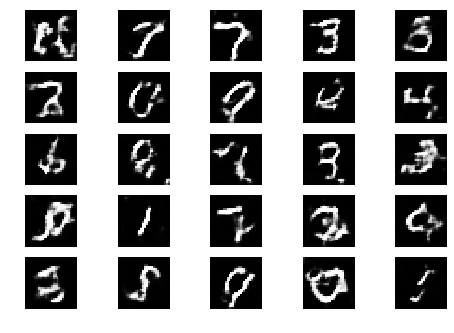

Epoch 0 Batch 1501/1875 [D loss: 0.561621, acc.: 68.75%] [G loss: 0.956950]
Epoch 0 Batch 1502/1875 [D loss: 0.607701, acc.: 71.88%] [G loss: 1.094207]
Epoch 0 Batch 1503/1875 [D loss: 0.574792, acc.: 71.88%] [G loss: 0.878714]
Epoch 0 Batch 1504/1875 [D loss: 0.658101, acc.: 65.62%] [G loss: 0.974392]
Epoch 0 Batch 1505/1875 [D loss: 0.729900, acc.: 40.62%] [G loss: 1.104307]
Epoch 0 Batch 1506/1875 [D loss: 0.642053, acc.: 56.25%] [G loss: 0.958888]
Epoch 0 Batch 1507/1875 [D loss: 0.654664, acc.: 59.38%] [G loss: 0.984064]
Epoch 0 Batch 1508/1875 [D loss: 0.616500, acc.: 59.38%] [G loss: 1.191414]
Epoch 0 Batch 1509/1875 [D loss: 0.685807, acc.: 53.12%] [G loss: 0.928205]
Epoch 0 Batch 1510/1875 [D loss: 0.869735, acc.: 34.38%] [G loss: 0.898643]
Epoch 0 Batch 1511/1875 [D loss: 0.680759, acc.: 59.38%] [G loss: 1.071838]
Epoch 0 Batch 1512/1875 [D loss: 0.724878, acc.: 59.38%] [G loss: 1.075645]
Epoch 0 Batch 1513/1875 [D loss: 0.675310, acc.: 56.25%] [G loss: 1.016477]
Epoch 0 Batc

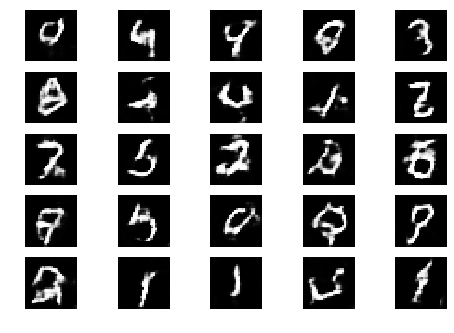

Epoch 0 Batch 1551/1875 [D loss: 0.677231, acc.: 65.62%] [G loss: 1.142523]
Epoch 0 Batch 1552/1875 [D loss: 0.708464, acc.: 53.12%] [G loss: 1.092625]
Epoch 0 Batch 1553/1875 [D loss: 0.608911, acc.: 68.75%] [G loss: 1.281897]
Epoch 0 Batch 1554/1875 [D loss: 0.701022, acc.: 62.50%] [G loss: 1.062977]
Epoch 0 Batch 1555/1875 [D loss: 0.475016, acc.: 81.25%] [G loss: 0.820224]
Epoch 0 Batch 1556/1875 [D loss: 0.665755, acc.: 62.50%] [G loss: 0.931791]
Epoch 0 Batch 1557/1875 [D loss: 0.497991, acc.: 75.00%] [G loss: 0.855249]
Epoch 0 Batch 1558/1875 [D loss: 0.824202, acc.: 46.88%] [G loss: 0.886374]
Epoch 0 Batch 1559/1875 [D loss: 0.638618, acc.: 62.50%] [G loss: 0.933470]
Epoch 0 Batch 1560/1875 [D loss: 0.663814, acc.: 62.50%] [G loss: 1.070368]
Epoch 0 Batch 1561/1875 [D loss: 0.484110, acc.: 75.00%] [G loss: 1.252491]
Epoch 0 Batch 1562/1875 [D loss: 0.526132, acc.: 78.12%] [G loss: 0.998764]
Epoch 0 Batch 1563/1875 [D loss: 0.722930, acc.: 53.12%] [G loss: 1.170973]
Epoch 0 Batc

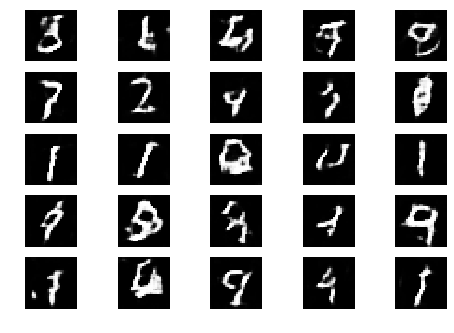

Epoch 0 Batch 1601/1875 [D loss: 0.582932, acc.: 81.25%] [G loss: 1.337028]
Epoch 0 Batch 1602/1875 [D loss: 0.724407, acc.: 53.12%] [G loss: 1.010889]
Epoch 0 Batch 1603/1875 [D loss: 0.598157, acc.: 65.62%] [G loss: 0.965708]
Epoch 0 Batch 1604/1875 [D loss: 0.836878, acc.: 40.62%] [G loss: 0.893793]
Epoch 0 Batch 1605/1875 [D loss: 0.768797, acc.: 50.00%] [G loss: 0.935831]
Epoch 0 Batch 1606/1875 [D loss: 0.767240, acc.: 50.00%] [G loss: 1.117034]
Epoch 0 Batch 1607/1875 [D loss: 0.706800, acc.: 59.38%] [G loss: 1.207425]
Epoch 0 Batch 1608/1875 [D loss: 0.603936, acc.: 62.50%] [G loss: 0.923236]
Epoch 0 Batch 1609/1875 [D loss: 0.633677, acc.: 65.62%] [G loss: 0.885033]
Epoch 0 Batch 1610/1875 [D loss: 0.694137, acc.: 46.88%] [G loss: 0.850069]
Epoch 0 Batch 1611/1875 [D loss: 0.659485, acc.: 50.00%] [G loss: 0.902697]
Epoch 0 Batch 1612/1875 [D loss: 0.709410, acc.: 53.12%] [G loss: 1.169934]
Epoch 0 Batch 1613/1875 [D loss: 0.656524, acc.: 65.62%] [G loss: 1.255787]
Epoch 0 Batc

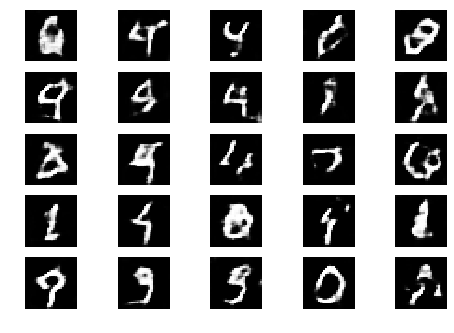

Epoch 0 Batch 1651/1875 [D loss: 0.608312, acc.: 71.88%] [G loss: 1.118226]
Epoch 0 Batch 1652/1875 [D loss: 0.598450, acc.: 75.00%] [G loss: 0.981577]
Epoch 0 Batch 1653/1875 [D loss: 0.788061, acc.: 53.12%] [G loss: 0.917525]
Epoch 0 Batch 1654/1875 [D loss: 0.563323, acc.: 68.75%] [G loss: 1.033875]
Epoch 0 Batch 1655/1875 [D loss: 0.676987, acc.: 53.12%] [G loss: 0.861784]
Epoch 0 Batch 1656/1875 [D loss: 0.757349, acc.: 43.75%] [G loss: 0.892946]
Epoch 0 Batch 1657/1875 [D loss: 0.638911, acc.: 68.75%] [G loss: 0.862231]
Epoch 0 Batch 1658/1875 [D loss: 0.754015, acc.: 50.00%] [G loss: 0.774217]
Epoch 0 Batch 1659/1875 [D loss: 0.560057, acc.: 71.88%] [G loss: 1.060112]
Epoch 0 Batch 1660/1875 [D loss: 0.572497, acc.: 75.00%] [G loss: 1.053082]
Epoch 0 Batch 1661/1875 [D loss: 0.736031, acc.: 53.12%] [G loss: 1.238873]
Epoch 0 Batch 1662/1875 [D loss: 0.736270, acc.: 62.50%] [G loss: 1.150964]
Epoch 0 Batch 1663/1875 [D loss: 0.698129, acc.: 59.38%] [G loss: 0.946844]
Epoch 0 Batc

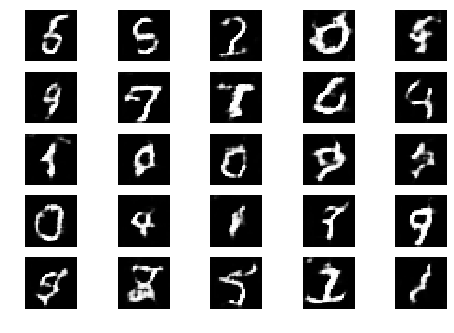

Epoch 0 Batch 1701/1875 [D loss: 0.723499, acc.: 56.25%] [G loss: 1.012454]
Epoch 0 Batch 1702/1875 [D loss: 0.584966, acc.: 78.12%] [G loss: 0.765982]
Epoch 0 Batch 1703/1875 [D loss: 0.583615, acc.: 75.00%] [G loss: 1.092326]
Epoch 0 Batch 1704/1875 [D loss: 0.557864, acc.: 71.88%] [G loss: 0.945195]
Epoch 0 Batch 1705/1875 [D loss: 0.723122, acc.: 59.38%] [G loss: 0.908680]
Epoch 0 Batch 1706/1875 [D loss: 0.520405, acc.: 78.12%] [G loss: 1.103309]
Epoch 0 Batch 1707/1875 [D loss: 0.681613, acc.: 62.50%] [G loss: 0.904714]
Epoch 0 Batch 1708/1875 [D loss: 0.676514, acc.: 62.50%] [G loss: 0.884472]
Epoch 0 Batch 1709/1875 [D loss: 0.720314, acc.: 53.12%] [G loss: 0.784865]
Epoch 0 Batch 1710/1875 [D loss: 0.994233, acc.: 31.25%] [G loss: 0.903876]
Epoch 0 Batch 1711/1875 [D loss: 0.676373, acc.: 50.00%] [G loss: 1.335164]
Epoch 0 Batch 1712/1875 [D loss: 0.796215, acc.: 46.88%] [G loss: 0.980291]
Epoch 0 Batch 1713/1875 [D loss: 0.597182, acc.: 65.62%] [G loss: 1.062559]
Epoch 0 Batc

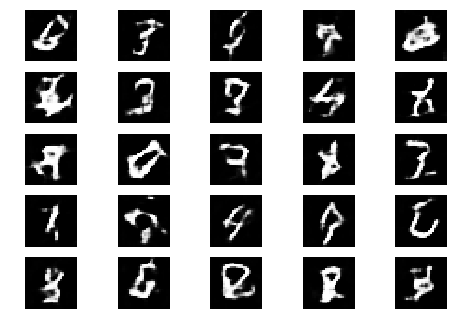

Epoch 0 Batch 1751/1875 [D loss: 0.576179, acc.: 71.88%] [G loss: 0.944175]
Epoch 0 Batch 1752/1875 [D loss: 0.568083, acc.: 78.12%] [G loss: 1.047052]
Epoch 0 Batch 1753/1875 [D loss: 0.809074, acc.: 50.00%] [G loss: 1.026120]
Epoch 0 Batch 1754/1875 [D loss: 0.769258, acc.: 53.12%] [G loss: 1.086240]
Epoch 0 Batch 1755/1875 [D loss: 0.717835, acc.: 46.88%] [G loss: 1.027211]
Epoch 0 Batch 1756/1875 [D loss: 0.729198, acc.: 50.00%] [G loss: 1.028108]
Epoch 0 Batch 1757/1875 [D loss: 0.769580, acc.: 43.75%] [G loss: 0.890926]
Epoch 0 Batch 1758/1875 [D loss: 0.752059, acc.: 53.12%] [G loss: 0.957458]
Epoch 0 Batch 1759/1875 [D loss: 0.738343, acc.: 56.25%] [G loss: 0.911853]
Epoch 0 Batch 1760/1875 [D loss: 0.613567, acc.: 65.62%] [G loss: 0.843395]
Epoch 0 Batch 1761/1875 [D loss: 0.705962, acc.: 53.12%] [G loss: 0.989156]
Epoch 0 Batch 1762/1875 [D loss: 0.756020, acc.: 53.12%] [G loss: 1.073041]
Epoch 0 Batch 1763/1875 [D loss: 0.826982, acc.: 31.25%] [G loss: 1.013663]
Epoch 0 Batc

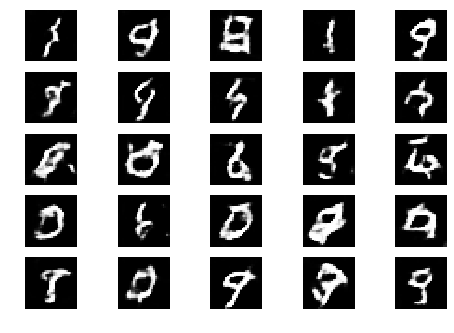

Epoch 0 Batch 1801/1875 [D loss: 0.636343, acc.: 65.62%] [G loss: 1.109221]
Epoch 0 Batch 1802/1875 [D loss: 0.679392, acc.: 50.00%] [G loss: 1.217979]
Epoch 0 Batch 1803/1875 [D loss: 0.693905, acc.: 59.38%] [G loss: 1.102302]
Epoch 0 Batch 1804/1875 [D loss: 0.665887, acc.: 59.38%] [G loss: 1.178230]
Epoch 0 Batch 1805/1875 [D loss: 0.609517, acc.: 62.50%] [G loss: 1.065067]
Epoch 0 Batch 1806/1875 [D loss: 0.856304, acc.: 53.12%] [G loss: 1.146271]
Epoch 0 Batch 1807/1875 [D loss: 0.676329, acc.: 65.62%] [G loss: 0.806505]
Epoch 0 Batch 1808/1875 [D loss: 0.620423, acc.: 65.62%] [G loss: 0.974424]
Epoch 0 Batch 1809/1875 [D loss: 0.599103, acc.: 68.75%] [G loss: 1.061021]
Epoch 0 Batch 1810/1875 [D loss: 0.564250, acc.: 78.12%] [G loss: 1.152227]
Epoch 0 Batch 1811/1875 [D loss: 0.593544, acc.: 65.62%] [G loss: 0.867099]
Epoch 0 Batch 1812/1875 [D loss: 0.682695, acc.: 53.12%] [G loss: 0.922562]
Epoch 0 Batch 1813/1875 [D loss: 0.534339, acc.: 78.12%] [G loss: 0.899519]
Epoch 0 Batc

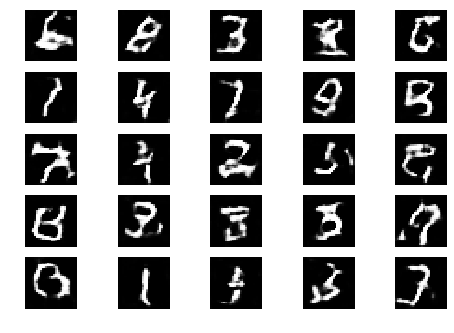

Epoch 0 Batch 1851/1875 [D loss: 0.623027, acc.: 71.88%] [G loss: 0.996736]
Epoch 0 Batch 1852/1875 [D loss: 0.581266, acc.: 71.88%] [G loss: 0.901228]
Epoch 0 Batch 1853/1875 [D loss: 0.571169, acc.: 68.75%] [G loss: 1.061441]
Epoch 0 Batch 1854/1875 [D loss: 0.699378, acc.: 59.38%] [G loss: 0.954600]
Epoch 0 Batch 1855/1875 [D loss: 0.720846, acc.: 53.12%] [G loss: 1.024785]
Epoch 0 Batch 1856/1875 [D loss: 0.495633, acc.: 75.00%] [G loss: 1.078045]
Epoch 0 Batch 1857/1875 [D loss: 0.738411, acc.: 62.50%] [G loss: 1.098325]
Epoch 0 Batch 1858/1875 [D loss: 0.641638, acc.: 65.62%] [G loss: 0.882074]
Epoch 0 Batch 1859/1875 [D loss: 0.648607, acc.: 56.25%] [G loss: 0.928296]
Epoch 0 Batch 1860/1875 [D loss: 0.600065, acc.: 65.62%] [G loss: 1.072850]
Epoch 0 Batch 1861/1875 [D loss: 0.506917, acc.: 81.25%] [G loss: 1.064548]
Epoch 0 Batch 1862/1875 [D loss: 0.767260, acc.: 53.12%] [G loss: 0.925248]
Epoch 0 Batch 1863/1875 [D loss: 0.603769, acc.: 65.62%] [G loss: 0.983649]
Epoch 0 Batc

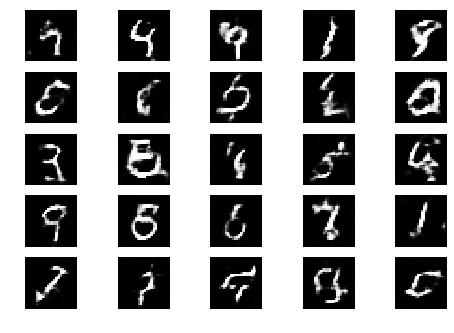

Epoch 1 Batch 1/1875 [D loss: 0.780194, acc.: 37.50%] [G loss: 1.178607]
Epoch 1 Batch 2/1875 [D loss: 0.785373, acc.: 43.75%] [G loss: 0.917141]
Epoch 1 Batch 3/1875 [D loss: 0.691484, acc.: 56.25%] [G loss: 1.022899]
Epoch 1 Batch 4/1875 [D loss: 0.659231, acc.: 53.12%] [G loss: 0.921965]
Epoch 1 Batch 5/1875 [D loss: 0.707336, acc.: 59.38%] [G loss: 1.013003]
Epoch 1 Batch 6/1875 [D loss: 0.735628, acc.: 56.25%] [G loss: 1.124337]
Epoch 1 Batch 7/1875 [D loss: 0.618626, acc.: 62.50%] [G loss: 1.280505]
Epoch 1 Batch 8/1875 [D loss: 0.799344, acc.: 46.88%] [G loss: 1.036543]
Epoch 1 Batch 9/1875 [D loss: 0.680801, acc.: 68.75%] [G loss: 0.900992]
Epoch 1 Batch 10/1875 [D loss: 0.674096, acc.: 56.25%] [G loss: 0.838619]
Epoch 1 Batch 11/1875 [D loss: 0.623038, acc.: 75.00%] [G loss: 0.932684]
Epoch 1 Batch 12/1875 [D loss: 0.777887, acc.: 40.62%] [G loss: 1.219945]
Epoch 1 Batch 13/1875 [D loss: 0.625082, acc.: 68.75%] [G loss: 1.180148]
Epoch 1 Batch 14/1875 [D loss: 0.742515, acc.: 

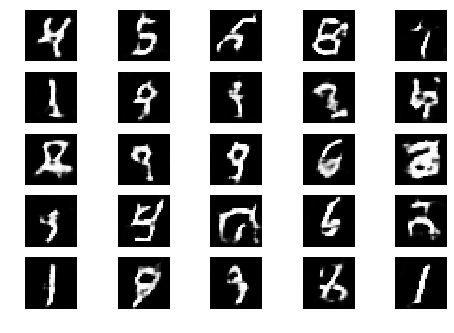

Epoch 1 Batch 51/1875 [D loss: 0.683355, acc.: 62.50%] [G loss: 1.142254]
Epoch 1 Batch 52/1875 [D loss: 0.706997, acc.: 53.12%] [G loss: 0.928111]
Epoch 1 Batch 53/1875 [D loss: 0.570300, acc.: 71.88%] [G loss: 0.873469]
Epoch 1 Batch 54/1875 [D loss: 0.617021, acc.: 56.25%] [G loss: 1.110931]
Epoch 1 Batch 55/1875 [D loss: 0.671985, acc.: 59.38%] [G loss: 0.954167]
Epoch 1 Batch 56/1875 [D loss: 0.600304, acc.: 65.62%] [G loss: 0.999157]
Epoch 1 Batch 57/1875 [D loss: 0.821008, acc.: 37.50%] [G loss: 1.058421]
Epoch 1 Batch 58/1875 [D loss: 0.643671, acc.: 59.38%] [G loss: 1.003639]
Epoch 1 Batch 59/1875 [D loss: 0.637072, acc.: 59.38%] [G loss: 0.907483]
Epoch 1 Batch 60/1875 [D loss: 0.685289, acc.: 59.38%] [G loss: 1.129594]
Epoch 1 Batch 61/1875 [D loss: 0.706678, acc.: 50.00%] [G loss: 0.927514]
Epoch 1 Batch 62/1875 [D loss: 0.794995, acc.: 53.12%] [G loss: 0.850049]
Epoch 1 Batch 63/1875 [D loss: 0.822118, acc.: 50.00%] [G loss: 0.962855]
Epoch 1 Batch 64/1875 [D loss: 0.63543

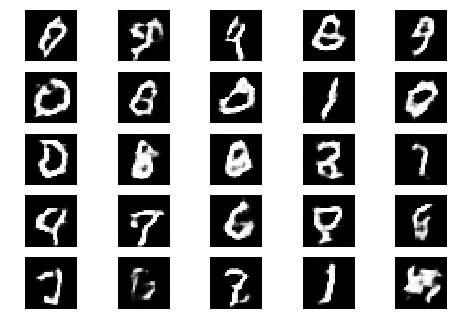

Epoch 1 Batch 101/1875 [D loss: 0.701334, acc.: 59.38%] [G loss: 0.873336]
Epoch 1 Batch 102/1875 [D loss: 0.572913, acc.: 65.62%] [G loss: 0.930546]
Epoch 1 Batch 103/1875 [D loss: 0.635921, acc.: 65.62%] [G loss: 0.921988]
Epoch 1 Batch 104/1875 [D loss: 0.781692, acc.: 50.00%] [G loss: 0.893668]
Epoch 1 Batch 105/1875 [D loss: 0.702428, acc.: 62.50%] [G loss: 0.805621]
Epoch 1 Batch 106/1875 [D loss: 0.743713, acc.: 53.12%] [G loss: 1.020239]
Epoch 1 Batch 107/1875 [D loss: 0.710241, acc.: 62.50%] [G loss: 1.159181]
Epoch 1 Batch 108/1875 [D loss: 0.579866, acc.: 71.88%] [G loss: 1.146681]
Epoch 1 Batch 109/1875 [D loss: 0.720765, acc.: 50.00%] [G loss: 1.128232]
Epoch 1 Batch 110/1875 [D loss: 0.643452, acc.: 65.62%] [G loss: 0.951252]
Epoch 1 Batch 111/1875 [D loss: 0.842311, acc.: 40.62%] [G loss: 0.974359]
Epoch 1 Batch 112/1875 [D loss: 0.807350, acc.: 53.12%] [G loss: 1.080356]
Epoch 1 Batch 113/1875 [D loss: 0.571378, acc.: 71.88%] [G loss: 1.084479]
Epoch 1 Batch 114/1875 [D

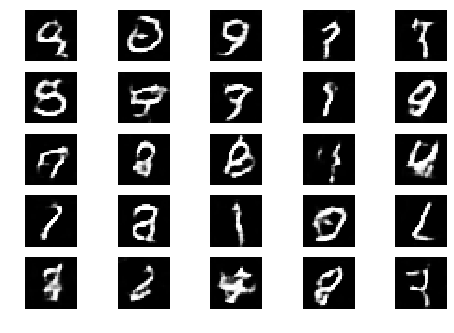

Epoch 1 Batch 151/1875 [D loss: 0.686245, acc.: 56.25%] [G loss: 1.075757]
Epoch 1 Batch 152/1875 [D loss: 0.748343, acc.: 50.00%] [G loss: 0.912574]
Epoch 1 Batch 153/1875 [D loss: 0.813220, acc.: 46.88%] [G loss: 1.119331]
Epoch 1 Batch 154/1875 [D loss: 0.653877, acc.: 62.50%] [G loss: 1.148494]
Epoch 1 Batch 155/1875 [D loss: 0.629801, acc.: 68.75%] [G loss: 1.163322]
Epoch 1 Batch 156/1875 [D loss: 0.629891, acc.: 71.88%] [G loss: 1.094077]
Epoch 1 Batch 157/1875 [D loss: 0.618035, acc.: 71.88%] [G loss: 1.053192]
Epoch 1 Batch 158/1875 [D loss: 0.717228, acc.: 65.62%] [G loss: 1.013241]
Epoch 1 Batch 159/1875 [D loss: 0.526535, acc.: 78.12%] [G loss: 0.840389]
Epoch 1 Batch 160/1875 [D loss: 0.704564, acc.: 53.12%] [G loss: 0.950154]
Epoch 1 Batch 161/1875 [D loss: 0.548082, acc.: 78.12%] [G loss: 1.146541]
Epoch 1 Batch 162/1875 [D loss: 0.748748, acc.: 56.25%] [G loss: 0.981806]
Epoch 1 Batch 163/1875 [D loss: 0.568471, acc.: 59.38%] [G loss: 0.993015]
Epoch 1 Batch 164/1875 [D

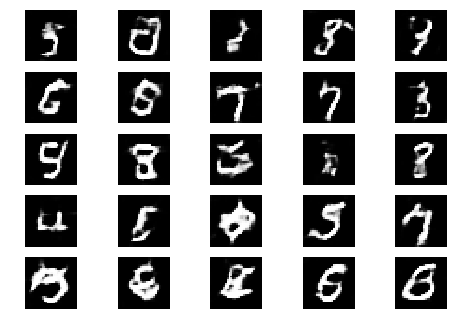

Epoch 1 Batch 201/1875 [D loss: 0.860466, acc.: 37.50%] [G loss: 1.029479]
Epoch 1 Batch 202/1875 [D loss: 0.725641, acc.: 68.75%] [G loss: 1.121917]
Epoch 1 Batch 203/1875 [D loss: 0.657149, acc.: 59.38%] [G loss: 1.125300]
Epoch 1 Batch 204/1875 [D loss: 0.800732, acc.: 50.00%] [G loss: 0.971980]
Epoch 1 Batch 205/1875 [D loss: 0.840837, acc.: 50.00%] [G loss: 1.132059]
Epoch 1 Batch 206/1875 [D loss: 0.831528, acc.: 37.50%] [G loss: 0.984039]
Epoch 1 Batch 207/1875 [D loss: 0.669231, acc.: 62.50%] [G loss: 0.993775]
Epoch 1 Batch 208/1875 [D loss: 0.477416, acc.: 84.38%] [G loss: 1.076286]
Epoch 1 Batch 209/1875 [D loss: 0.652871, acc.: 56.25%] [G loss: 0.940862]
Epoch 1 Batch 210/1875 [D loss: 0.777259, acc.: 46.88%] [G loss: 0.976102]
Epoch 1 Batch 211/1875 [D loss: 0.661557, acc.: 68.75%] [G loss: 0.866375]
Epoch 1 Batch 212/1875 [D loss: 0.819368, acc.: 40.62%] [G loss: 1.081761]
Epoch 1 Batch 213/1875 [D loss: 0.605440, acc.: 68.75%] [G loss: 0.776572]
Epoch 1 Batch 214/1875 [D

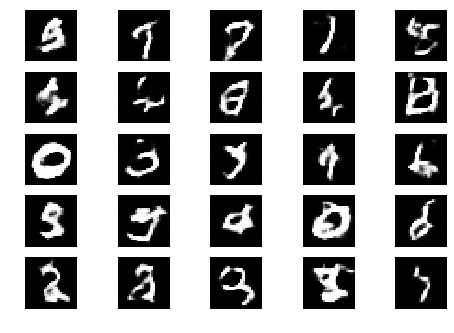

Epoch 1 Batch 251/1875 [D loss: 0.577307, acc.: 71.88%] [G loss: 0.939157]
Epoch 1 Batch 252/1875 [D loss: 0.644423, acc.: 62.50%] [G loss: 1.144984]
Epoch 1 Batch 253/1875 [D loss: 0.641565, acc.: 62.50%] [G loss: 0.976895]
Epoch 1 Batch 254/1875 [D loss: 0.757525, acc.: 53.12%] [G loss: 0.899986]
Epoch 1 Batch 255/1875 [D loss: 0.655049, acc.: 65.62%] [G loss: 0.859207]
Epoch 1 Batch 256/1875 [D loss: 0.775389, acc.: 40.62%] [G loss: 0.843562]
Epoch 1 Batch 257/1875 [D loss: 0.843584, acc.: 37.50%] [G loss: 0.956849]
Epoch 1 Batch 258/1875 [D loss: 0.576074, acc.: 65.62%] [G loss: 0.880077]
Epoch 1 Batch 259/1875 [D loss: 0.575288, acc.: 75.00%] [G loss: 1.037453]
Epoch 1 Batch 260/1875 [D loss: 0.685339, acc.: 56.25%] [G loss: 1.019848]
Epoch 1 Batch 261/1875 [D loss: 0.605848, acc.: 59.38%] [G loss: 1.167853]
Epoch 1 Batch 262/1875 [D loss: 0.596012, acc.: 62.50%] [G loss: 1.032634]
Epoch 1 Batch 263/1875 [D loss: 0.830865, acc.: 43.75%] [G loss: 1.186537]
Epoch 1 Batch 264/1875 [D

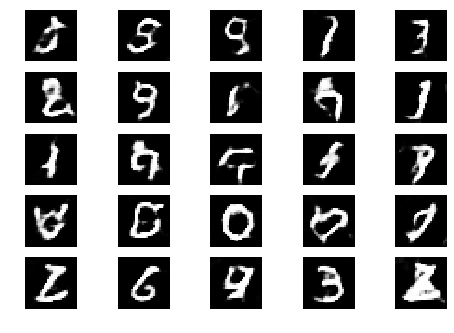

Epoch 1 Batch 301/1875 [D loss: 0.770035, acc.: 53.12%] [G loss: 0.946592]
Epoch 1 Batch 302/1875 [D loss: 0.593497, acc.: 65.62%] [G loss: 0.869322]
Epoch 1 Batch 303/1875 [D loss: 0.581122, acc.: 71.88%] [G loss: 0.942004]
Epoch 1 Batch 304/1875 [D loss: 0.626297, acc.: 62.50%] [G loss: 0.858641]
Epoch 1 Batch 305/1875 [D loss: 0.788024, acc.: 40.62%] [G loss: 1.076049]
Epoch 1 Batch 306/1875 [D loss: 0.669391, acc.: 53.12%] [G loss: 1.251451]
Epoch 1 Batch 307/1875 [D loss: 0.646840, acc.: 56.25%] [G loss: 1.161820]
Epoch 1 Batch 308/1875 [D loss: 0.653136, acc.: 62.50%] [G loss: 0.963586]
Epoch 1 Batch 309/1875 [D loss: 0.616979, acc.: 65.62%] [G loss: 1.014384]
Epoch 1 Batch 310/1875 [D loss: 0.688167, acc.: 65.62%] [G loss: 1.099386]
Epoch 1 Batch 311/1875 [D loss: 0.508385, acc.: 78.12%] [G loss: 1.113968]
Epoch 1 Batch 312/1875 [D loss: 0.777178, acc.: 43.75%] [G loss: 1.047026]
Epoch 1 Batch 313/1875 [D loss: 0.867736, acc.: 43.75%] [G loss: 0.963881]
Epoch 1 Batch 314/1875 [D

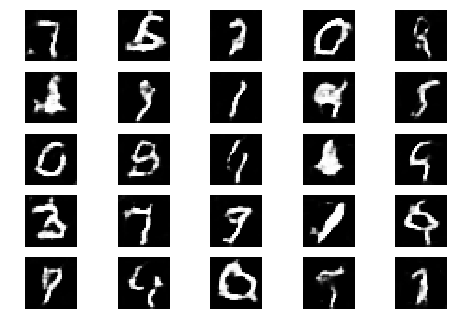

Epoch 1 Batch 351/1875 [D loss: 0.620374, acc.: 50.00%] [G loss: 0.931006]
Epoch 1 Batch 352/1875 [D loss: 0.664376, acc.: 53.12%] [G loss: 0.972086]
Epoch 1 Batch 353/1875 [D loss: 0.588158, acc.: 68.75%] [G loss: 1.016765]
Epoch 1 Batch 354/1875 [D loss: 0.493689, acc.: 81.25%] [G loss: 0.826952]
Epoch 1 Batch 355/1875 [D loss: 0.787393, acc.: 50.00%] [G loss: 0.828769]
Epoch 1 Batch 356/1875 [D loss: 0.667722, acc.: 56.25%] [G loss: 1.083420]
Epoch 1 Batch 357/1875 [D loss: 0.542336, acc.: 71.88%] [G loss: 1.007803]
Epoch 1 Batch 358/1875 [D loss: 0.596732, acc.: 65.62%] [G loss: 1.217522]
Epoch 1 Batch 359/1875 [D loss: 0.629002, acc.: 62.50%] [G loss: 1.201404]
Epoch 1 Batch 360/1875 [D loss: 0.594945, acc.: 71.88%] [G loss: 1.136338]
Epoch 1 Batch 361/1875 [D loss: 0.757372, acc.: 50.00%] [G loss: 1.019025]
Epoch 1 Batch 362/1875 [D loss: 0.736259, acc.: 50.00%] [G loss: 1.084787]
Epoch 1 Batch 363/1875 [D loss: 0.738126, acc.: 50.00%] [G loss: 1.019810]
Epoch 1 Batch 364/1875 [D

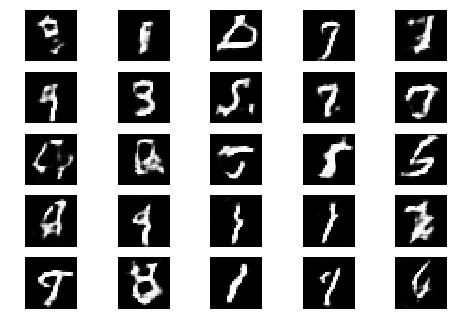

Epoch 1 Batch 401/1875 [D loss: 0.590968, acc.: 75.00%] [G loss: 1.006951]
Epoch 1 Batch 402/1875 [D loss: 0.875350, acc.: 37.50%] [G loss: 0.716155]
Epoch 1 Batch 403/1875 [D loss: 0.669511, acc.: 68.75%] [G loss: 0.932427]
Epoch 1 Batch 404/1875 [D loss: 0.632461, acc.: 62.50%] [G loss: 0.944415]
Epoch 1 Batch 405/1875 [D loss: 0.681738, acc.: 53.12%] [G loss: 1.080111]
Epoch 1 Batch 406/1875 [D loss: 0.716930, acc.: 46.88%] [G loss: 0.896094]
Epoch 1 Batch 407/1875 [D loss: 0.702682, acc.: 53.12%] [G loss: 1.128300]
Epoch 1 Batch 408/1875 [D loss: 0.595122, acc.: 71.88%] [G loss: 1.135066]
Epoch 1 Batch 409/1875 [D loss: 0.734311, acc.: 46.88%] [G loss: 0.911770]
Epoch 1 Batch 410/1875 [D loss: 0.596779, acc.: 65.62%] [G loss: 0.940622]
Epoch 1 Batch 411/1875 [D loss: 0.718626, acc.: 71.88%] [G loss: 0.804308]
Epoch 1 Batch 412/1875 [D loss: 0.676152, acc.: 65.62%] [G loss: 0.881249]
Epoch 1 Batch 413/1875 [D loss: 0.639358, acc.: 68.75%] [G loss: 0.887136]
Epoch 1 Batch 414/1875 [D

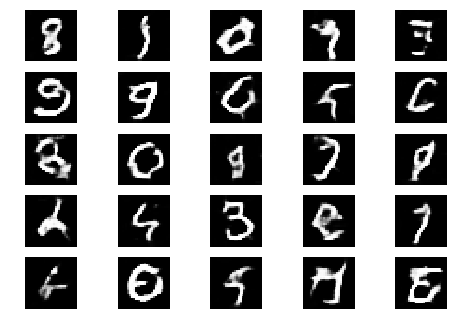

Epoch 1 Batch 451/1875 [D loss: 0.630838, acc.: 62.50%] [G loss: 0.886173]
Epoch 1 Batch 452/1875 [D loss: 0.560928, acc.: 75.00%] [G loss: 1.048152]
Epoch 1 Batch 453/1875 [D loss: 0.631344, acc.: 65.62%] [G loss: 1.013189]
Epoch 1 Batch 454/1875 [D loss: 0.658963, acc.: 53.12%] [G loss: 1.137132]
Epoch 1 Batch 455/1875 [D loss: 0.726309, acc.: 43.75%] [G loss: 0.979227]
Epoch 1 Batch 456/1875 [D loss: 0.584334, acc.: 71.88%] [G loss: 1.122002]
Epoch 1 Batch 457/1875 [D loss: 0.626931, acc.: 62.50%] [G loss: 1.096523]
Epoch 1 Batch 458/1875 [D loss: 0.567014, acc.: 71.88%] [G loss: 1.017534]
Epoch 1 Batch 459/1875 [D loss: 0.750497, acc.: 50.00%] [G loss: 1.199951]
Epoch 1 Batch 460/1875 [D loss: 0.685846, acc.: 50.00%] [G loss: 0.986639]
Epoch 1 Batch 461/1875 [D loss: 0.721132, acc.: 53.12%] [G loss: 0.928186]
Epoch 1 Batch 462/1875 [D loss: 0.786976, acc.: 56.25%] [G loss: 1.045645]
Epoch 1 Batch 463/1875 [D loss: 0.572110, acc.: 71.88%] [G loss: 0.944754]
Epoch 1 Batch 464/1875 [D

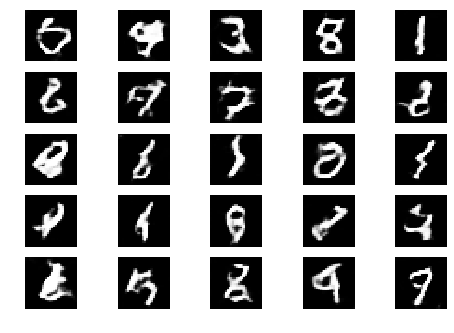

Epoch 1 Batch 501/1875 [D loss: 0.593146, acc.: 65.62%] [G loss: 0.978098]
Epoch 1 Batch 502/1875 [D loss: 0.627930, acc.: 65.62%] [G loss: 0.974818]
Epoch 1 Batch 503/1875 [D loss: 0.694639, acc.: 65.62%] [G loss: 0.932145]
Epoch 1 Batch 504/1875 [D loss: 0.725287, acc.: 50.00%] [G loss: 0.931190]
Epoch 1 Batch 505/1875 [D loss: 0.800504, acc.: 59.38%] [G loss: 0.993548]
Epoch 1 Batch 506/1875 [D loss: 0.582703, acc.: 71.88%] [G loss: 0.940518]
Epoch 1 Batch 507/1875 [D loss: 0.507644, acc.: 78.12%] [G loss: 0.761571]
Epoch 1 Batch 508/1875 [D loss: 0.730272, acc.: 50.00%] [G loss: 0.732410]
Epoch 1 Batch 509/1875 [D loss: 0.670639, acc.: 53.12%] [G loss: 0.852378]
Epoch 1 Batch 510/1875 [D loss: 0.808349, acc.: 53.12%] [G loss: 0.971885]
Epoch 1 Batch 511/1875 [D loss: 0.815067, acc.: 40.62%] [G loss: 0.780029]
Epoch 1 Batch 512/1875 [D loss: 0.724564, acc.: 53.12%] [G loss: 0.855274]
Epoch 1 Batch 513/1875 [D loss: 0.618654, acc.: 65.62%] [G loss: 0.956000]
Epoch 1 Batch 514/1875 [D

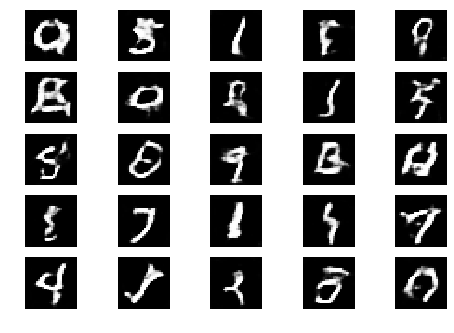

Epoch 1 Batch 551/1875 [D loss: 0.808902, acc.: 43.75%] [G loss: 1.026435]
Epoch 1 Batch 552/1875 [D loss: 0.747467, acc.: 46.88%] [G loss: 1.137439]
Epoch 1 Batch 553/1875 [D loss: 0.666001, acc.: 71.88%] [G loss: 0.856881]
Epoch 1 Batch 554/1875 [D loss: 0.572132, acc.: 65.62%] [G loss: 1.006121]
Epoch 1 Batch 555/1875 [D loss: 0.636138, acc.: 62.50%] [G loss: 0.892490]
Epoch 1 Batch 556/1875 [D loss: 0.777784, acc.: 46.88%] [G loss: 0.804813]
Epoch 1 Batch 557/1875 [D loss: 0.596687, acc.: 65.62%] [G loss: 1.016479]
Epoch 1 Batch 558/1875 [D loss: 0.799764, acc.: 50.00%] [G loss: 0.860094]
Epoch 1 Batch 559/1875 [D loss: 0.587632, acc.: 65.62%] [G loss: 1.097960]
Epoch 1 Batch 560/1875 [D loss: 0.750179, acc.: 46.88%] [G loss: 1.072833]
Epoch 1 Batch 561/1875 [D loss: 0.565761, acc.: 68.75%] [G loss: 1.030381]
Epoch 1 Batch 562/1875 [D loss: 0.746748, acc.: 56.25%] [G loss: 0.956561]
Epoch 1 Batch 563/1875 [D loss: 0.617356, acc.: 68.75%] [G loss: 0.940378]
Epoch 1 Batch 564/1875 [D

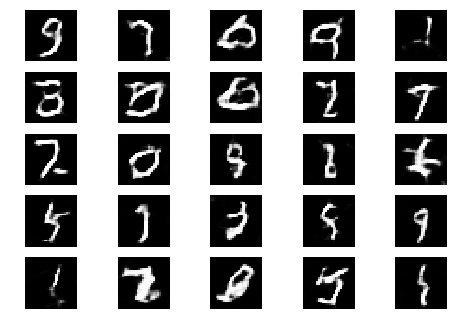

Epoch 1 Batch 601/1875 [D loss: 0.816136, acc.: 50.00%] [G loss: 0.929460]
Epoch 1 Batch 602/1875 [D loss: 0.786089, acc.: 43.75%] [G loss: 0.974637]
Epoch 1 Batch 603/1875 [D loss: 0.472246, acc.: 84.38%] [G loss: 0.973334]
Epoch 1 Batch 604/1875 [D loss: 0.743658, acc.: 50.00%] [G loss: 0.868433]
Epoch 1 Batch 605/1875 [D loss: 0.777164, acc.: 43.75%] [G loss: 1.138626]
Epoch 1 Batch 606/1875 [D loss: 0.722605, acc.: 46.88%] [G loss: 0.936487]
Epoch 1 Batch 607/1875 [D loss: 0.606789, acc.: 68.75%] [G loss: 1.181868]
Epoch 1 Batch 608/1875 [D loss: 0.710353, acc.: 65.62%] [G loss: 0.906781]
Epoch 1 Batch 609/1875 [D loss: 0.558785, acc.: 75.00%] [G loss: 0.983232]
Epoch 1 Batch 610/1875 [D loss: 0.702914, acc.: 59.38%] [G loss: 1.058006]
Epoch 1 Batch 611/1875 [D loss: 0.808299, acc.: 40.62%] [G loss: 0.950936]
Epoch 1 Batch 612/1875 [D loss: 0.634621, acc.: 59.38%] [G loss: 0.865755]
Epoch 1 Batch 613/1875 [D loss: 0.710444, acc.: 53.12%] [G loss: 0.893149]
Epoch 1 Batch 614/1875 [D

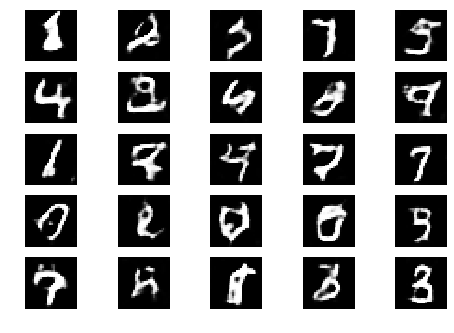

Epoch 1 Batch 651/1875 [D loss: 0.688432, acc.: 53.12%] [G loss: 0.850171]
Epoch 1 Batch 652/1875 [D loss: 0.617943, acc.: 65.62%] [G loss: 0.999605]
Epoch 1 Batch 653/1875 [D loss: 0.746475, acc.: 59.38%] [G loss: 1.125910]
Epoch 1 Batch 654/1875 [D loss: 0.763420, acc.: 46.88%] [G loss: 1.005226]
Epoch 1 Batch 655/1875 [D loss: 0.712056, acc.: 53.12%] [G loss: 1.077009]
Epoch 1 Batch 656/1875 [D loss: 0.680179, acc.: 65.62%] [G loss: 0.978551]
Epoch 1 Batch 657/1875 [D loss: 0.743870, acc.: 53.12%] [G loss: 1.021906]
Epoch 1 Batch 658/1875 [D loss: 0.663315, acc.: 53.12%] [G loss: 1.150759]
Epoch 1 Batch 659/1875 [D loss: 0.658766, acc.: 56.25%] [G loss: 0.831421]
Epoch 1 Batch 660/1875 [D loss: 0.564602, acc.: 68.75%] [G loss: 1.031677]
Epoch 1 Batch 661/1875 [D loss: 0.573158, acc.: 65.62%] [G loss: 1.162166]
Epoch 1 Batch 662/1875 [D loss: 0.755356, acc.: 53.12%] [G loss: 0.979953]
Epoch 1 Batch 663/1875 [D loss: 0.780620, acc.: 46.88%] [G loss: 0.979963]
Epoch 1 Batch 664/1875 [D

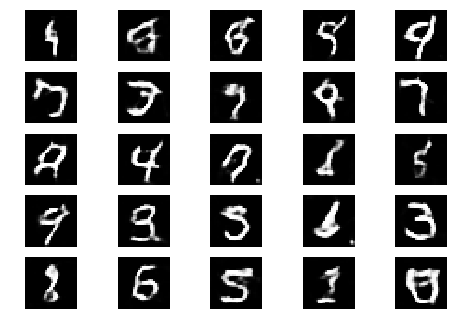

Epoch 1 Batch 701/1875 [D loss: 0.597377, acc.: 71.88%] [G loss: 1.007176]
Epoch 1 Batch 702/1875 [D loss: 0.646327, acc.: 56.25%] [G loss: 1.063860]
Epoch 1 Batch 703/1875 [D loss: 0.528042, acc.: 78.12%] [G loss: 0.947055]
Epoch 1 Batch 704/1875 [D loss: 0.754798, acc.: 62.50%] [G loss: 1.129611]
Epoch 1 Batch 705/1875 [D loss: 0.975161, acc.: 28.12%] [G loss: 0.884157]
Epoch 1 Batch 706/1875 [D loss: 0.701316, acc.: 56.25%] [G loss: 0.843632]
Epoch 1 Batch 707/1875 [D loss: 0.652395, acc.: 56.25%] [G loss: 0.899979]
Epoch 1 Batch 708/1875 [D loss: 0.609187, acc.: 68.75%] [G loss: 0.894855]
Epoch 1 Batch 709/1875 [D loss: 0.672918, acc.: 59.38%] [G loss: 1.080181]
Epoch 1 Batch 710/1875 [D loss: 0.563739, acc.: 75.00%] [G loss: 0.829200]
Epoch 1 Batch 711/1875 [D loss: 0.648492, acc.: 68.75%] [G loss: 0.897129]
Epoch 1 Batch 712/1875 [D loss: 0.655367, acc.: 65.62%] [G loss: 1.018021]
Epoch 1 Batch 713/1875 [D loss: 0.552368, acc.: 75.00%] [G loss: 0.721549]
Epoch 1 Batch 714/1875 [D

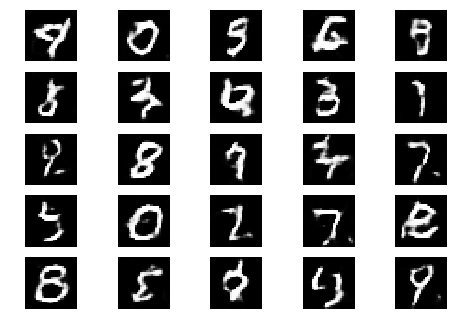

Epoch 1 Batch 751/1875 [D loss: 0.719005, acc.: 53.12%] [G loss: 0.922636]
Epoch 1 Batch 752/1875 [D loss: 0.668113, acc.: 56.25%] [G loss: 0.883418]
Epoch 1 Batch 753/1875 [D loss: 0.572810, acc.: 65.62%] [G loss: 1.030417]
Epoch 1 Batch 754/1875 [D loss: 0.688208, acc.: 56.25%] [G loss: 0.775202]
Epoch 1 Batch 755/1875 [D loss: 0.679851, acc.: 59.38%] [G loss: 0.909265]
Epoch 1 Batch 756/1875 [D loss: 0.604757, acc.: 78.12%] [G loss: 1.072050]
Epoch 1 Batch 757/1875 [D loss: 0.647517, acc.: 68.75%] [G loss: 1.061350]
Epoch 1 Batch 758/1875 [D loss: 0.786274, acc.: 43.75%] [G loss: 1.074006]
Epoch 1 Batch 759/1875 [D loss: 0.669077, acc.: 65.62%] [G loss: 0.990249]
Epoch 1 Batch 760/1875 [D loss: 0.670718, acc.: 68.75%] [G loss: 1.176675]
Epoch 1 Batch 761/1875 [D loss: 0.750549, acc.: 50.00%] [G loss: 0.909595]
Epoch 1 Batch 762/1875 [D loss: 0.540273, acc.: 68.75%] [G loss: 0.911432]
Epoch 1 Batch 763/1875 [D loss: 0.660575, acc.: 65.62%] [G loss: 1.019305]
Epoch 1 Batch 764/1875 [D

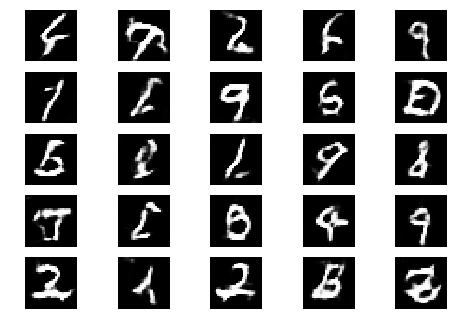

Epoch 1 Batch 801/1875 [D loss: 0.716442, acc.: 53.12%] [G loss: 0.915856]
Epoch 1 Batch 802/1875 [D loss: 0.652168, acc.: 56.25%] [G loss: 1.091821]
Epoch 1 Batch 803/1875 [D loss: 0.723746, acc.: 50.00%] [G loss: 1.052851]
Epoch 1 Batch 804/1875 [D loss: 0.571661, acc.: 68.75%] [G loss: 1.057317]
Epoch 1 Batch 805/1875 [D loss: 0.589945, acc.: 78.12%] [G loss: 1.186536]
Epoch 1 Batch 806/1875 [D loss: 0.693229, acc.: 53.12%] [G loss: 0.969642]
Epoch 1 Batch 807/1875 [D loss: 0.656897, acc.: 62.50%] [G loss: 0.901469]
Epoch 1 Batch 808/1875 [D loss: 0.667483, acc.: 71.88%] [G loss: 1.010123]
Epoch 1 Batch 809/1875 [D loss: 0.639484, acc.: 68.75%] [G loss: 1.129406]
Epoch 1 Batch 810/1875 [D loss: 0.649041, acc.: 65.62%] [G loss: 1.143092]
Epoch 1 Batch 811/1875 [D loss: 0.507155, acc.: 84.38%] [G loss: 0.862250]
Epoch 1 Batch 812/1875 [D loss: 0.671296, acc.: 62.50%] [G loss: 0.945137]
Epoch 1 Batch 813/1875 [D loss: 0.724646, acc.: 50.00%] [G loss: 1.049448]
Epoch 1 Batch 814/1875 [D

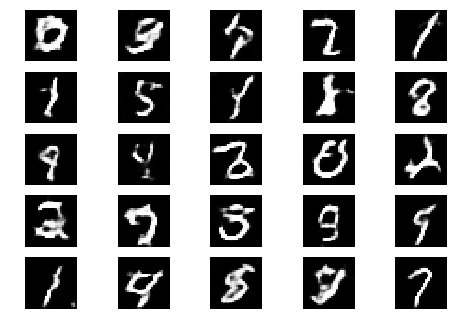

Epoch 1 Batch 851/1875 [D loss: 0.724021, acc.: 53.12%] [G loss: 0.737970]
Epoch 1 Batch 852/1875 [D loss: 0.680784, acc.: 62.50%] [G loss: 0.960393]
Epoch 1 Batch 853/1875 [D loss: 0.580079, acc.: 62.50%] [G loss: 1.058260]
Epoch 1 Batch 854/1875 [D loss: 0.760106, acc.: 53.12%] [G loss: 0.994179]
Epoch 1 Batch 855/1875 [D loss: 0.707702, acc.: 65.62%] [G loss: 0.853219]
Epoch 1 Batch 856/1875 [D loss: 0.744724, acc.: 62.50%] [G loss: 1.030176]
Epoch 1 Batch 857/1875 [D loss: 0.602828, acc.: 65.62%] [G loss: 0.988521]
Epoch 1 Batch 858/1875 [D loss: 0.539961, acc.: 78.12%] [G loss: 1.153618]
Epoch 1 Batch 859/1875 [D loss: 0.577014, acc.: 71.88%] [G loss: 1.104477]
Epoch 1 Batch 860/1875 [D loss: 0.563602, acc.: 75.00%] [G loss: 1.029331]
Epoch 1 Batch 861/1875 [D loss: 0.656208, acc.: 50.00%] [G loss: 1.109586]
Epoch 1 Batch 862/1875 [D loss: 0.638337, acc.: 65.62%] [G loss: 0.986458]
Epoch 1 Batch 863/1875 [D loss: 0.618611, acc.: 68.75%] [G loss: 1.046192]
Epoch 1 Batch 864/1875 [D

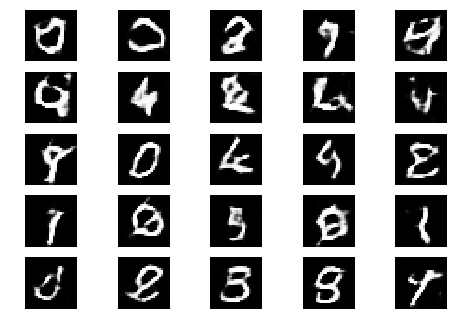

Epoch 1 Batch 901/1875 [D loss: 0.763703, acc.: 46.88%] [G loss: 0.983139]
Epoch 1 Batch 902/1875 [D loss: 0.623619, acc.: 65.62%] [G loss: 1.008121]
Epoch 1 Batch 903/1875 [D loss: 0.647019, acc.: 56.25%] [G loss: 1.048470]
Epoch 1 Batch 904/1875 [D loss: 0.826687, acc.: 40.62%] [G loss: 1.125867]
Epoch 1 Batch 905/1875 [D loss: 0.728040, acc.: 40.62%] [G loss: 1.147546]
Epoch 1 Batch 906/1875 [D loss: 0.548814, acc.: 75.00%] [G loss: 1.103417]
Epoch 1 Batch 907/1875 [D loss: 0.749867, acc.: 46.88%] [G loss: 0.864836]
Epoch 1 Batch 908/1875 [D loss: 0.742362, acc.: 53.12%] [G loss: 1.008175]
Epoch 1 Batch 909/1875 [D loss: 0.654586, acc.: 65.62%] [G loss: 0.950411]
Epoch 1 Batch 910/1875 [D loss: 0.760170, acc.: 62.50%] [G loss: 0.948416]
Epoch 1 Batch 911/1875 [D loss: 0.667664, acc.: 65.62%] [G loss: 0.882274]
Epoch 1 Batch 912/1875 [D loss: 0.709041, acc.: 56.25%] [G loss: 0.852870]
Epoch 1 Batch 913/1875 [D loss: 0.631115, acc.: 68.75%] [G loss: 0.932567]
Epoch 1 Batch 914/1875 [D

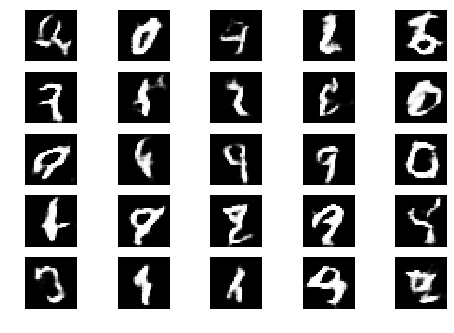

Epoch 1 Batch 951/1875 [D loss: 0.575869, acc.: 75.00%] [G loss: 0.914349]
Epoch 1 Batch 952/1875 [D loss: 0.566739, acc.: 65.62%] [G loss: 0.886241]
Epoch 1 Batch 953/1875 [D loss: 0.604511, acc.: 68.75%] [G loss: 0.994872]
Epoch 1 Batch 954/1875 [D loss: 0.649496, acc.: 62.50%] [G loss: 1.007687]
Epoch 1 Batch 955/1875 [D loss: 0.829071, acc.: 50.00%] [G loss: 0.951294]
Epoch 1 Batch 956/1875 [D loss: 0.613918, acc.: 65.62%] [G loss: 1.094013]
Epoch 1 Batch 957/1875 [D loss: 0.559946, acc.: 75.00%] [G loss: 0.835652]
Epoch 1 Batch 958/1875 [D loss: 0.645003, acc.: 65.62%] [G loss: 1.146158]
Epoch 1 Batch 959/1875 [D loss: 0.617349, acc.: 65.62%] [G loss: 0.818067]
Epoch 1 Batch 960/1875 [D loss: 0.681631, acc.: 56.25%] [G loss: 0.764791]
Epoch 1 Batch 961/1875 [D loss: 0.753618, acc.: 50.00%] [G loss: 0.997389]
Epoch 1 Batch 962/1875 [D loss: 0.822526, acc.: 40.62%] [G loss: 1.047357]
Epoch 1 Batch 963/1875 [D loss: 0.705027, acc.: 46.88%] [G loss: 1.109038]
Epoch 1 Batch 964/1875 [D

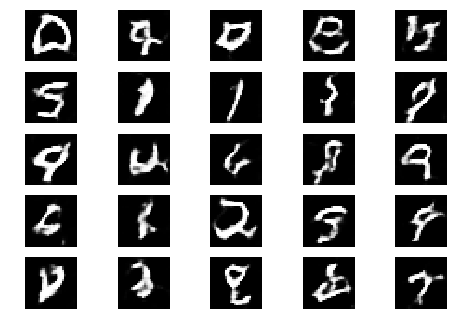

Epoch 1 Batch 1001/1875 [D loss: 0.727429, acc.: 53.12%] [G loss: 0.850865]
Epoch 1 Batch 1002/1875 [D loss: 0.601654, acc.: 62.50%] [G loss: 0.804033]
Epoch 1 Batch 1003/1875 [D loss: 0.520707, acc.: 81.25%] [G loss: 0.957171]
Epoch 1 Batch 1004/1875 [D loss: 0.712034, acc.: 59.38%] [G loss: 0.920315]
Epoch 1 Batch 1005/1875 [D loss: 0.648472, acc.: 62.50%] [G loss: 0.993125]
Epoch 1 Batch 1006/1875 [D loss: 0.680004, acc.: 59.38%] [G loss: 0.919030]
Epoch 1 Batch 1007/1875 [D loss: 0.657946, acc.: 56.25%] [G loss: 1.100947]
Epoch 1 Batch 1008/1875 [D loss: 0.523239, acc.: 68.75%] [G loss: 1.012020]
Epoch 1 Batch 1009/1875 [D loss: 0.584822, acc.: 68.75%] [G loss: 0.982901]
Epoch 1 Batch 1010/1875 [D loss: 0.810784, acc.: 53.12%] [G loss: 0.926463]
Epoch 1 Batch 1011/1875 [D loss: 0.832560, acc.: 43.75%] [G loss: 0.944447]
Epoch 1 Batch 1012/1875 [D loss: 0.557186, acc.: 65.62%] [G loss: 0.969575]
Epoch 1 Batch 1013/1875 [D loss: 0.596699, acc.: 68.75%] [G loss: 0.864191]
Epoch 1 Batc

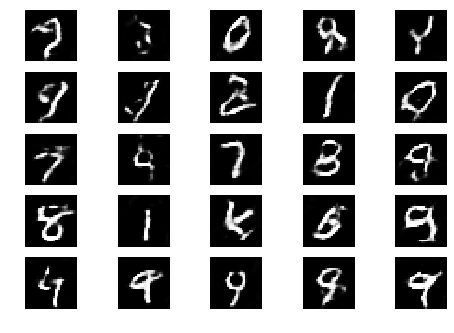

Epoch 1 Batch 1051/1875 [D loss: 0.665997, acc.: 59.38%] [G loss: 0.997455]
Epoch 1 Batch 1052/1875 [D loss: 0.625935, acc.: 62.50%] [G loss: 1.097459]
Epoch 1 Batch 1053/1875 [D loss: 0.712617, acc.: 46.88%] [G loss: 1.047821]
Epoch 1 Batch 1054/1875 [D loss: 0.547658, acc.: 78.12%] [G loss: 0.986669]
Epoch 1 Batch 1055/1875 [D loss: 0.669359, acc.: 65.62%] [G loss: 0.963136]
Epoch 1 Batch 1056/1875 [D loss: 0.729609, acc.: 46.88%] [G loss: 0.995715]
Epoch 1 Batch 1057/1875 [D loss: 0.719533, acc.: 50.00%] [G loss: 1.024033]
Epoch 1 Batch 1058/1875 [D loss: 0.658751, acc.: 62.50%] [G loss: 1.001889]
Epoch 1 Batch 1059/1875 [D loss: 0.581072, acc.: 68.75%] [G loss: 1.114500]
Epoch 1 Batch 1060/1875 [D loss: 0.677719, acc.: 53.12%] [G loss: 0.920527]
Epoch 1 Batch 1061/1875 [D loss: 0.434019, acc.: 93.75%] [G loss: 0.938741]
Epoch 1 Batch 1062/1875 [D loss: 0.649070, acc.: 62.50%] [G loss: 0.937447]
Epoch 1 Batch 1063/1875 [D loss: 0.606603, acc.: 65.62%] [G loss: 0.931462]
Epoch 1 Batc

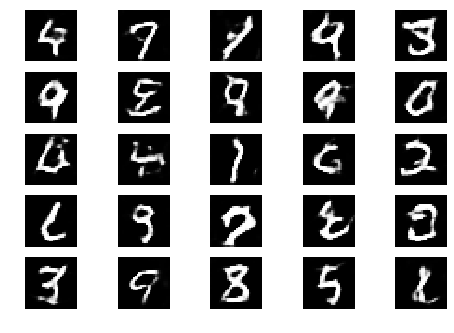

Epoch 1 Batch 1101/1875 [D loss: 0.775151, acc.: 43.75%] [G loss: 0.932759]
Epoch 1 Batch 1102/1875 [D loss: 0.699056, acc.: 50.00%] [G loss: 1.049293]
Epoch 1 Batch 1103/1875 [D loss: 0.634535, acc.: 56.25%] [G loss: 1.099732]
Epoch 1 Batch 1104/1875 [D loss: 0.669033, acc.: 53.12%] [G loss: 0.961161]
Epoch 1 Batch 1105/1875 [D loss: 0.567362, acc.: 65.62%] [G loss: 0.950820]
Epoch 1 Batch 1106/1875 [D loss: 0.634337, acc.: 59.38%] [G loss: 0.992375]
Epoch 1 Batch 1107/1875 [D loss: 0.570414, acc.: 78.12%] [G loss: 0.900241]
Epoch 1 Batch 1108/1875 [D loss: 0.708036, acc.: 56.25%] [G loss: 0.889500]
Epoch 1 Batch 1109/1875 [D loss: 0.614956, acc.: 71.88%] [G loss: 0.998300]
Epoch 1 Batch 1110/1875 [D loss: 0.590620, acc.: 62.50%] [G loss: 0.969518]
Epoch 1 Batch 1111/1875 [D loss: 0.623848, acc.: 68.75%] [G loss: 0.907728]
Epoch 1 Batch 1112/1875 [D loss: 0.806723, acc.: 40.62%] [G loss: 0.952647]
Epoch 1 Batch 1113/1875 [D loss: 0.684163, acc.: 59.38%] [G loss: 0.868226]
Epoch 1 Batc

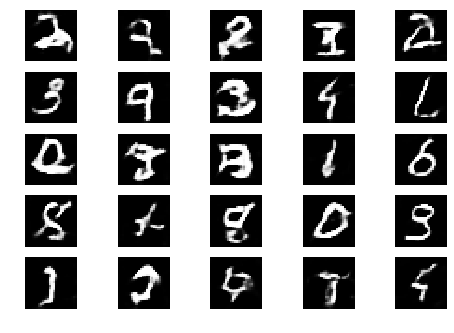

Epoch 1 Batch 1151/1875 [D loss: 0.571708, acc.: 68.75%] [G loss: 0.835226]
Epoch 1 Batch 1152/1875 [D loss: 0.629177, acc.: 59.38%] [G loss: 0.944579]
Epoch 1 Batch 1153/1875 [D loss: 0.701633, acc.: 59.38%] [G loss: 0.927611]
Epoch 1 Batch 1154/1875 [D loss: 0.667241, acc.: 56.25%] [G loss: 0.787738]
Epoch 1 Batch 1155/1875 [D loss: 0.564369, acc.: 71.88%] [G loss: 0.921951]
Epoch 1 Batch 1156/1875 [D loss: 0.635980, acc.: 62.50%] [G loss: 1.051270]
Epoch 1 Batch 1157/1875 [D loss: 0.613885, acc.: 71.88%] [G loss: 0.966098]
Epoch 1 Batch 1158/1875 [D loss: 0.564680, acc.: 71.88%] [G loss: 1.099763]
Epoch 1 Batch 1159/1875 [D loss: 0.681654, acc.: 56.25%] [G loss: 0.981189]
Epoch 1 Batch 1160/1875 [D loss: 0.649450, acc.: 62.50%] [G loss: 1.056690]
Epoch 1 Batch 1161/1875 [D loss: 0.663800, acc.: 50.00%] [G loss: 1.060731]
Epoch 1 Batch 1162/1875 [D loss: 0.685248, acc.: 56.25%] [G loss: 0.938873]
Epoch 1 Batch 1163/1875 [D loss: 0.636252, acc.: 65.62%] [G loss: 0.929433]
Epoch 1 Batc

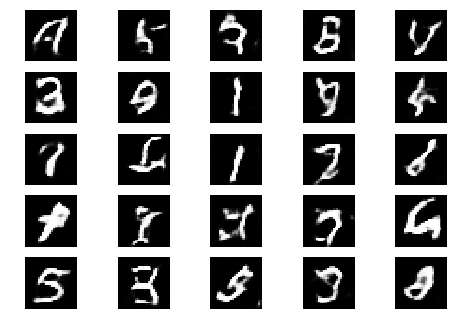

Epoch 1 Batch 1201/1875 [D loss: 0.567058, acc.: 75.00%] [G loss: 0.947873]
Epoch 1 Batch 1202/1875 [D loss: 0.638628, acc.: 62.50%] [G loss: 0.982268]
Epoch 1 Batch 1203/1875 [D loss: 0.721053, acc.: 65.62%] [G loss: 1.048731]
Epoch 1 Batch 1204/1875 [D loss: 0.679814, acc.: 50.00%] [G loss: 0.936883]
Epoch 1 Batch 1205/1875 [D loss: 0.669872, acc.: 56.25%] [G loss: 0.878977]
Epoch 1 Batch 1206/1875 [D loss: 0.665634, acc.: 62.50%] [G loss: 0.943933]
Epoch 1 Batch 1207/1875 [D loss: 0.737302, acc.: 59.38%] [G loss: 0.835402]
Epoch 1 Batch 1208/1875 [D loss: 0.614995, acc.: 65.62%] [G loss: 1.088653]
Epoch 1 Batch 1209/1875 [D loss: 0.569440, acc.: 68.75%] [G loss: 0.938141]
Epoch 1 Batch 1210/1875 [D loss: 0.633105, acc.: 62.50%] [G loss: 1.214112]
Epoch 1 Batch 1211/1875 [D loss: 0.650879, acc.: 56.25%] [G loss: 1.061885]
Epoch 1 Batch 1212/1875 [D loss: 0.729154, acc.: 59.38%] [G loss: 0.984689]
Epoch 1 Batch 1213/1875 [D loss: 0.586829, acc.: 75.00%] [G loss: 0.863533]
Epoch 1 Batc

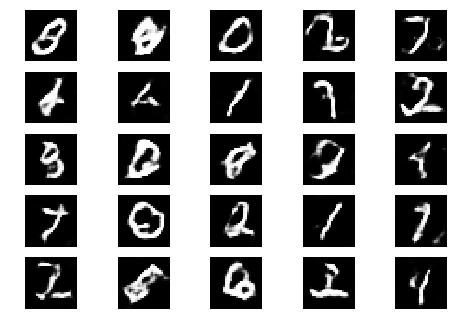

Epoch 1 Batch 1251/1875 [D loss: 0.629469, acc.: 75.00%] [G loss: 1.016851]
Epoch 1 Batch 1252/1875 [D loss: 0.535829, acc.: 65.62%] [G loss: 0.891537]
Epoch 1 Batch 1253/1875 [D loss: 0.663737, acc.: 59.38%] [G loss: 0.966059]
Epoch 1 Batch 1254/1875 [D loss: 0.736626, acc.: 59.38%] [G loss: 0.777444]
Epoch 1 Batch 1255/1875 [D loss: 0.717051, acc.: 59.38%] [G loss: 0.850324]
Epoch 1 Batch 1256/1875 [D loss: 0.664071, acc.: 62.50%] [G loss: 1.033469]
Epoch 1 Batch 1257/1875 [D loss: 0.707663, acc.: 53.12%] [G loss: 0.888213]
Epoch 1 Batch 1258/1875 [D loss: 0.603486, acc.: 65.62%] [G loss: 0.936051]
Epoch 1 Batch 1259/1875 [D loss: 0.595723, acc.: 65.62%] [G loss: 1.161121]
Epoch 1 Batch 1260/1875 [D loss: 0.573206, acc.: 71.88%] [G loss: 1.086403]
Epoch 1 Batch 1261/1875 [D loss: 0.881226, acc.: 37.50%] [G loss: 0.966637]
Epoch 1 Batch 1262/1875 [D loss: 0.707801, acc.: 65.62%] [G loss: 0.938366]
Epoch 1 Batch 1263/1875 [D loss: 0.675801, acc.: 56.25%] [G loss: 0.852680]
Epoch 1 Batc

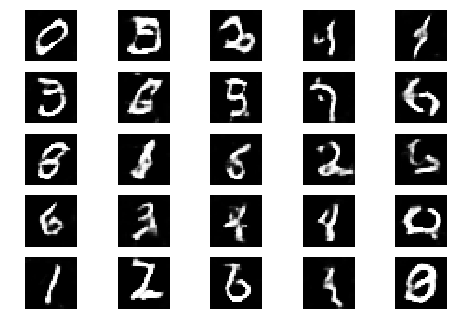

Epoch 1 Batch 1301/1875 [D loss: 0.764862, acc.: 50.00%] [G loss: 0.968221]
Epoch 1 Batch 1302/1875 [D loss: 0.633495, acc.: 71.88%] [G loss: 0.986174]
Epoch 1 Batch 1303/1875 [D loss: 0.832387, acc.: 43.75%] [G loss: 0.870600]
Epoch 1 Batch 1304/1875 [D loss: 0.597323, acc.: 71.88%] [G loss: 0.862374]
Epoch 1 Batch 1305/1875 [D loss: 0.535650, acc.: 71.88%] [G loss: 0.868908]
Epoch 1 Batch 1306/1875 [D loss: 0.659420, acc.: 65.62%] [G loss: 0.910913]
Epoch 1 Batch 1307/1875 [D loss: 0.835114, acc.: 34.38%] [G loss: 0.868214]
Epoch 1 Batch 1308/1875 [D loss: 0.710368, acc.: 62.50%] [G loss: 0.903430]
Epoch 1 Batch 1309/1875 [D loss: 0.688027, acc.: 62.50%] [G loss: 0.866551]
Epoch 1 Batch 1310/1875 [D loss: 0.506858, acc.: 84.38%] [G loss: 0.894252]
Epoch 1 Batch 1311/1875 [D loss: 0.771839, acc.: 43.75%] [G loss: 0.743272]
Epoch 1 Batch 1312/1875 [D loss: 0.694751, acc.: 53.12%] [G loss: 0.825428]
Epoch 1 Batch 1313/1875 [D loss: 0.650332, acc.: 62.50%] [G loss: 0.977533]
Epoch 1 Batc

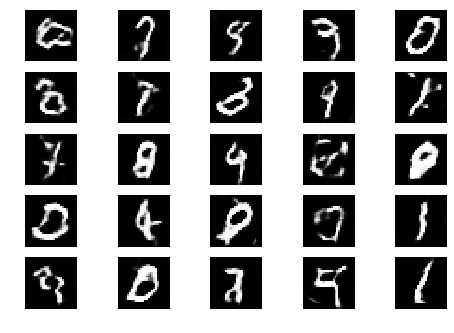

Epoch 1 Batch 1351/1875 [D loss: 0.746415, acc.: 43.75%] [G loss: 0.736863]
Epoch 1 Batch 1352/1875 [D loss: 0.687451, acc.: 50.00%] [G loss: 0.925332]
Epoch 1 Batch 1353/1875 [D loss: 0.473967, acc.: 78.12%] [G loss: 0.929507]
Epoch 1 Batch 1354/1875 [D loss: 0.610337, acc.: 65.62%] [G loss: 0.815594]
Epoch 1 Batch 1355/1875 [D loss: 0.710215, acc.: 59.38%] [G loss: 1.018641]
Epoch 1 Batch 1356/1875 [D loss: 0.658365, acc.: 62.50%] [G loss: 0.955257]
Epoch 1 Batch 1357/1875 [D loss: 0.581681, acc.: 65.62%] [G loss: 0.853144]
Epoch 1 Batch 1358/1875 [D loss: 0.660973, acc.: 59.38%] [G loss: 1.086411]
Epoch 1 Batch 1359/1875 [D loss: 0.749971, acc.: 56.25%] [G loss: 1.025462]
Epoch 1 Batch 1360/1875 [D loss: 0.614172, acc.: 65.62%] [G loss: 1.063935]
Epoch 1 Batch 1361/1875 [D loss: 0.835397, acc.: 43.75%] [G loss: 0.848704]
Epoch 1 Batch 1362/1875 [D loss: 0.601466, acc.: 71.88%] [G loss: 1.033853]
Epoch 1 Batch 1363/1875 [D loss: 0.609605, acc.: 65.62%] [G loss: 1.122528]
Epoch 1 Batc

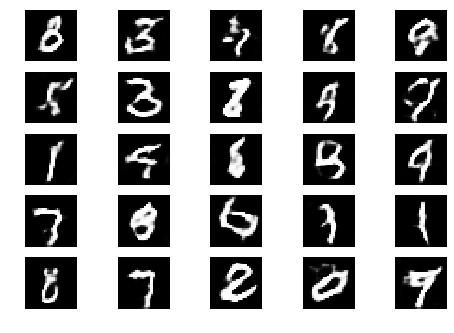

Epoch 1 Batch 1401/1875 [D loss: 0.611481, acc.: 68.75%] [G loss: 1.091213]
Epoch 1 Batch 1402/1875 [D loss: 0.613251, acc.: 65.62%] [G loss: 1.192048]
Epoch 1 Batch 1403/1875 [D loss: 0.639499, acc.: 65.62%] [G loss: 1.150030]
Epoch 1 Batch 1404/1875 [D loss: 0.790285, acc.: 43.75%] [G loss: 1.067697]
Epoch 1 Batch 1405/1875 [D loss: 0.749972, acc.: 53.12%] [G loss: 0.857679]
Epoch 1 Batch 1406/1875 [D loss: 0.629528, acc.: 65.62%] [G loss: 1.063916]
Epoch 1 Batch 1407/1875 [D loss: 0.683612, acc.: 53.12%] [G loss: 0.916164]
Epoch 1 Batch 1408/1875 [D loss: 0.760892, acc.: 43.75%] [G loss: 0.903058]
Epoch 1 Batch 1409/1875 [D loss: 0.594219, acc.: 71.88%] [G loss: 0.864694]
Epoch 1 Batch 1410/1875 [D loss: 0.691144, acc.: 59.38%] [G loss: 0.729812]
Epoch 1 Batch 1411/1875 [D loss: 0.539743, acc.: 68.75%] [G loss: 0.973746]
Epoch 1 Batch 1412/1875 [D loss: 0.845806, acc.: 50.00%] [G loss: 0.977406]
Epoch 1 Batch 1413/1875 [D loss: 0.589660, acc.: 68.75%] [G loss: 0.726395]
Epoch 1 Batc

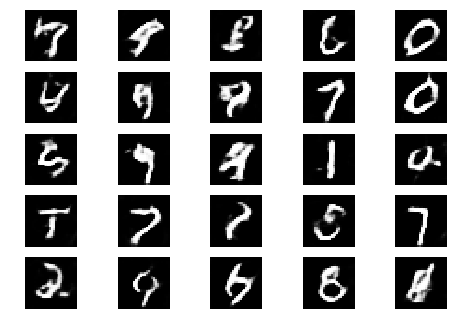

Epoch 1 Batch 1451/1875 [D loss: 0.731289, acc.: 46.88%] [G loss: 1.045436]
Epoch 1 Batch 1452/1875 [D loss: 0.739558, acc.: 43.75%] [G loss: 1.045185]
Epoch 1 Batch 1453/1875 [D loss: 0.741645, acc.: 59.38%] [G loss: 0.894262]
Epoch 1 Batch 1454/1875 [D loss: 0.730559, acc.: 56.25%] [G loss: 1.100953]
Epoch 1 Batch 1455/1875 [D loss: 0.591416, acc.: 68.75%] [G loss: 0.826281]
Epoch 1 Batch 1456/1875 [D loss: 0.715291, acc.: 46.88%] [G loss: 0.903440]
Epoch 1 Batch 1457/1875 [D loss: 0.619361, acc.: 59.38%] [G loss: 0.887369]
Epoch 1 Batch 1458/1875 [D loss: 0.696564, acc.: 50.00%] [G loss: 0.986761]
Epoch 1 Batch 1459/1875 [D loss: 0.595492, acc.: 68.75%] [G loss: 0.915275]
Epoch 1 Batch 1460/1875 [D loss: 0.676365, acc.: 59.38%] [G loss: 0.921602]
Epoch 1 Batch 1461/1875 [D loss: 0.719955, acc.: 46.88%] [G loss: 0.953157]
Epoch 1 Batch 1462/1875 [D loss: 0.606738, acc.: 65.62%] [G loss: 1.030663]
Epoch 1 Batch 1463/1875 [D loss: 0.541454, acc.: 71.88%] [G loss: 1.098522]
Epoch 1 Batc

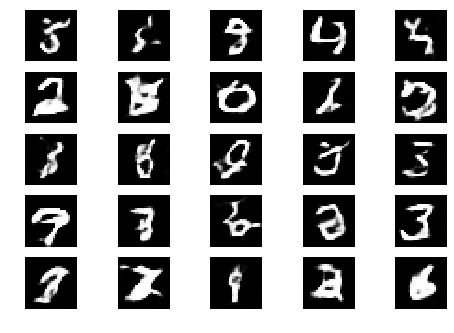

Epoch 1 Batch 1501/1875 [D loss: 0.798769, acc.: 50.00%] [G loss: 0.845122]
Epoch 1 Batch 1502/1875 [D loss: 0.594887, acc.: 75.00%] [G loss: 0.827219]
Epoch 1 Batch 1503/1875 [D loss: 0.694235, acc.: 68.75%] [G loss: 0.898267]
Epoch 1 Batch 1504/1875 [D loss: 0.569355, acc.: 75.00%] [G loss: 0.895451]
Epoch 1 Batch 1505/1875 [D loss: 0.497202, acc.: 78.12%] [G loss: 0.891027]
Epoch 1 Batch 1506/1875 [D loss: 0.576430, acc.: 62.50%] [G loss: 0.722313]
Epoch 1 Batch 1507/1875 [D loss: 0.777361, acc.: 43.75%] [G loss: 0.847655]
Epoch 1 Batch 1508/1875 [D loss: 0.634580, acc.: 59.38%] [G loss: 1.018502]
Epoch 1 Batch 1509/1875 [D loss: 0.733620, acc.: 43.75%] [G loss: 1.068231]
Epoch 1 Batch 1510/1875 [D loss: 0.711620, acc.: 56.25%] [G loss: 0.835222]
Epoch 1 Batch 1511/1875 [D loss: 0.668054, acc.: 59.38%] [G loss: 0.991700]
Epoch 1 Batch 1512/1875 [D loss: 0.860975, acc.: 34.38%] [G loss: 0.792365]
Epoch 1 Batch 1513/1875 [D loss: 0.805766, acc.: 50.00%] [G loss: 0.743214]
Epoch 1 Batc

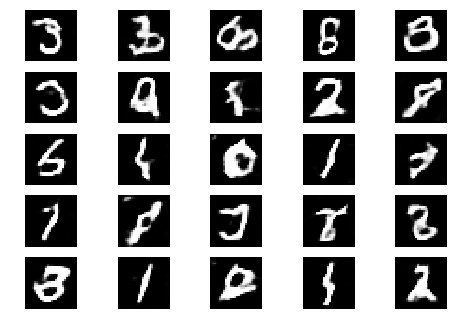

Epoch 1 Batch 1551/1875 [D loss: 0.627344, acc.: 62.50%] [G loss: 0.956053]
Epoch 1 Batch 1552/1875 [D loss: 0.590997, acc.: 78.12%] [G loss: 0.988149]
Epoch 1 Batch 1553/1875 [D loss: 0.707939, acc.: 53.12%] [G loss: 0.963789]
Epoch 1 Batch 1554/1875 [D loss: 0.573424, acc.: 75.00%] [G loss: 1.070279]
Epoch 1 Batch 1555/1875 [D loss: 0.744593, acc.: 59.38%] [G loss: 0.860943]
Epoch 1 Batch 1556/1875 [D loss: 0.645342, acc.: 56.25%] [G loss: 0.888937]
Epoch 1 Batch 1557/1875 [D loss: 0.664460, acc.: 62.50%] [G loss: 1.085301]
Epoch 1 Batch 1558/1875 [D loss: 0.536721, acc.: 65.62%] [G loss: 1.217212]
Epoch 1 Batch 1559/1875 [D loss: 0.563749, acc.: 71.88%] [G loss: 0.839704]
Epoch 1 Batch 1560/1875 [D loss: 0.595628, acc.: 78.12%] [G loss: 0.885105]
Epoch 1 Batch 1561/1875 [D loss: 0.648132, acc.: 62.50%] [G loss: 0.911153]
Epoch 1 Batch 1562/1875 [D loss: 0.552990, acc.: 75.00%] [G loss: 0.956426]
Epoch 1 Batch 1563/1875 [D loss: 0.538414, acc.: 71.88%] [G loss: 0.995424]
Epoch 1 Batc

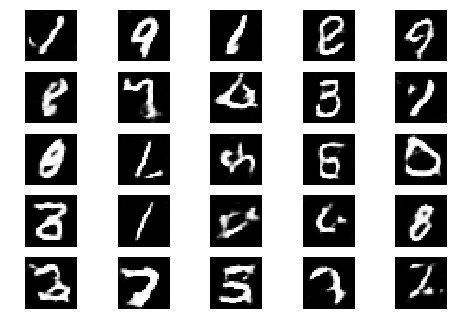

Epoch 1 Batch 1601/1875 [D loss: 0.582649, acc.: 71.88%] [G loss: 1.007442]
Epoch 1 Batch 1602/1875 [D loss: 0.629242, acc.: 62.50%] [G loss: 1.115221]
Epoch 1 Batch 1603/1875 [D loss: 0.650087, acc.: 59.38%] [G loss: 1.027463]
Epoch 1 Batch 1604/1875 [D loss: 0.682467, acc.: 65.62%] [G loss: 0.917611]
Epoch 1 Batch 1605/1875 [D loss: 0.572331, acc.: 71.88%] [G loss: 1.115776]
Epoch 1 Batch 1606/1875 [D loss: 0.641821, acc.: 68.75%] [G loss: 0.885807]
Epoch 1 Batch 1607/1875 [D loss: 0.654193, acc.: 62.50%] [G loss: 1.057535]
Epoch 1 Batch 1608/1875 [D loss: 0.730356, acc.: 53.12%] [G loss: 1.163802]
Epoch 1 Batch 1609/1875 [D loss: 0.633139, acc.: 59.38%] [G loss: 0.877090]
Epoch 1 Batch 1610/1875 [D loss: 0.702646, acc.: 56.25%] [G loss: 0.895892]
Epoch 1 Batch 1611/1875 [D loss: 0.704437, acc.: 53.12%] [G loss: 0.827454]
Epoch 1 Batch 1612/1875 [D loss: 0.525188, acc.: 78.12%] [G loss: 0.878707]
Epoch 1 Batch 1613/1875 [D loss: 0.618401, acc.: 62.50%] [G loss: 1.032459]
Epoch 1 Batc

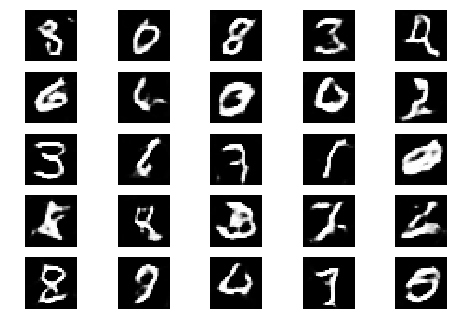

Epoch 1 Batch 1651/1875 [D loss: 0.677121, acc.: 59.38%] [G loss: 1.126026]
Epoch 1 Batch 1652/1875 [D loss: 0.640231, acc.: 68.75%] [G loss: 1.184466]
Epoch 1 Batch 1653/1875 [D loss: 0.657486, acc.: 65.62%] [G loss: 0.927498]
Epoch 1 Batch 1654/1875 [D loss: 0.706269, acc.: 50.00%] [G loss: 1.042658]
Epoch 1 Batch 1655/1875 [D loss: 0.583234, acc.: 68.75%] [G loss: 1.006217]
Epoch 1 Batch 1656/1875 [D loss: 0.642412, acc.: 62.50%] [G loss: 0.953942]
Epoch 1 Batch 1657/1875 [D loss: 0.689043, acc.: 53.12%] [G loss: 0.941752]
Epoch 1 Batch 1658/1875 [D loss: 0.689167, acc.: 50.00%] [G loss: 0.896287]
Epoch 1 Batch 1659/1875 [D loss: 0.749725, acc.: 50.00%] [G loss: 0.954811]
Epoch 1 Batch 1660/1875 [D loss: 0.740710, acc.: 59.38%] [G loss: 0.814699]
Epoch 1 Batch 1661/1875 [D loss: 0.740500, acc.: 53.12%] [G loss: 0.838699]
Epoch 1 Batch 1662/1875 [D loss: 0.559531, acc.: 78.12%] [G loss: 0.834906]
Epoch 1 Batch 1663/1875 [D loss: 0.646313, acc.: 65.62%] [G loss: 0.959282]
Epoch 1 Batc

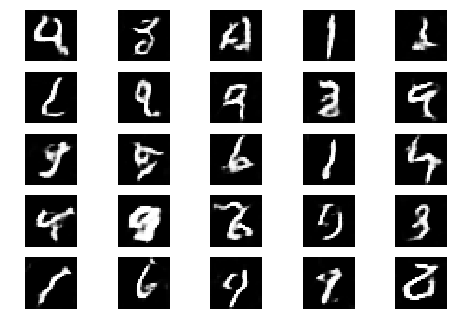

Epoch 1 Batch 1701/1875 [D loss: 0.554113, acc.: 78.12%] [G loss: 1.159276]
Epoch 1 Batch 1702/1875 [D loss: 0.694240, acc.: 50.00%] [G loss: 0.916725]
Epoch 1 Batch 1703/1875 [D loss: 0.721693, acc.: 62.50%] [G loss: 1.083832]
Epoch 1 Batch 1704/1875 [D loss: 0.700831, acc.: 59.38%] [G loss: 1.062141]
Epoch 1 Batch 1705/1875 [D loss: 0.630880, acc.: 62.50%] [G loss: 0.935327]
Epoch 1 Batch 1706/1875 [D loss: 0.616348, acc.: 75.00%] [G loss: 0.915930]
Epoch 1 Batch 1707/1875 [D loss: 0.578281, acc.: 68.75%] [G loss: 0.910568]
Epoch 1 Batch 1708/1875 [D loss: 0.735399, acc.: 50.00%] [G loss: 1.049488]
Epoch 1 Batch 1709/1875 [D loss: 0.727929, acc.: 56.25%] [G loss: 1.057484]
Epoch 1 Batch 1710/1875 [D loss: 0.655891, acc.: 62.50%] [G loss: 1.112759]
Epoch 1 Batch 1711/1875 [D loss: 0.635714, acc.: 65.62%] [G loss: 0.988910]
Epoch 1 Batch 1712/1875 [D loss: 0.704361, acc.: 50.00%] [G loss: 0.867143]
Epoch 1 Batch 1713/1875 [D loss: 0.647074, acc.: 53.12%] [G loss: 0.859588]
Epoch 1 Batc

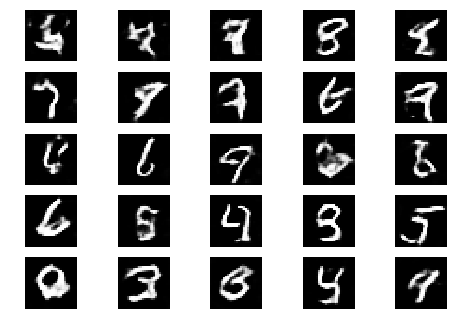

Epoch 1 Batch 1751/1875 [D loss: 0.739126, acc.: 43.75%] [G loss: 0.742245]
Epoch 1 Batch 1752/1875 [D loss: 0.738953, acc.: 46.88%] [G loss: 1.000111]
Epoch 1 Batch 1753/1875 [D loss: 0.611704, acc.: 65.62%] [G loss: 0.984720]
Epoch 1 Batch 1754/1875 [D loss: 0.641231, acc.: 65.62%] [G loss: 1.031937]
Epoch 1 Batch 1755/1875 [D loss: 0.619105, acc.: 62.50%] [G loss: 1.156623]
Epoch 1 Batch 1756/1875 [D loss: 0.601255, acc.: 62.50%] [G loss: 1.077100]
Epoch 1 Batch 1757/1875 [D loss: 0.623578, acc.: 59.38%] [G loss: 0.919636]
Epoch 1 Batch 1758/1875 [D loss: 0.585111, acc.: 68.75%] [G loss: 1.075864]
Epoch 1 Batch 1759/1875 [D loss: 0.588262, acc.: 75.00%] [G loss: 1.102797]
Epoch 1 Batch 1760/1875 [D loss: 0.766385, acc.: 43.75%] [G loss: 1.054800]
Epoch 1 Batch 1761/1875 [D loss: 0.744578, acc.: 56.25%] [G loss: 0.979542]
Epoch 1 Batch 1762/1875 [D loss: 0.587370, acc.: 65.62%] [G loss: 1.159664]
Epoch 1 Batch 1763/1875 [D loss: 0.619960, acc.: 65.62%] [G loss: 0.937673]
Epoch 1 Batc

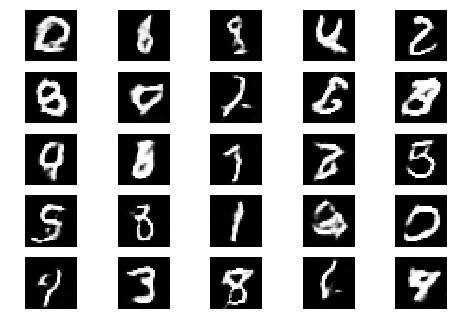

Epoch 1 Batch 1801/1875 [D loss: 0.821791, acc.: 46.88%] [G loss: 0.977652]
Epoch 1 Batch 1802/1875 [D loss: 0.733372, acc.: 59.38%] [G loss: 0.944050]
Epoch 1 Batch 1803/1875 [D loss: 0.682744, acc.: 59.38%] [G loss: 0.859742]
Epoch 1 Batch 1804/1875 [D loss: 0.603579, acc.: 71.88%] [G loss: 1.009338]
Epoch 1 Batch 1805/1875 [D loss: 0.640592, acc.: 62.50%] [G loss: 1.085025]
Epoch 1 Batch 1806/1875 [D loss: 0.760464, acc.: 56.25%] [G loss: 1.078799]
Epoch 1 Batch 1807/1875 [D loss: 0.838789, acc.: 40.62%] [G loss: 1.037580]
Epoch 1 Batch 1808/1875 [D loss: 0.517451, acc.: 81.25%] [G loss: 1.173162]
Epoch 1 Batch 1809/1875 [D loss: 0.541551, acc.: 75.00%] [G loss: 1.238009]
Epoch 1 Batch 1810/1875 [D loss: 0.576030, acc.: 78.12%] [G loss: 1.061748]
Epoch 1 Batch 1811/1875 [D loss: 0.779938, acc.: 40.62%] [G loss: 0.986003]
Epoch 1 Batch 1812/1875 [D loss: 0.640253, acc.: 71.88%] [G loss: 0.907840]
Epoch 1 Batch 1813/1875 [D loss: 0.742337, acc.: 50.00%] [G loss: 0.831040]
Epoch 1 Batc

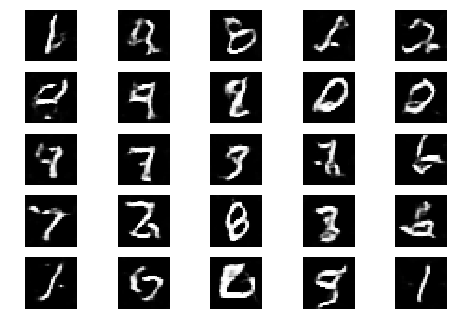

Epoch 1 Batch 1851/1875 [D loss: 0.565418, acc.: 65.62%] [G loss: 1.006210]
Epoch 1 Batch 1852/1875 [D loss: 0.636792, acc.: 53.12%] [G loss: 0.923877]
Epoch 1 Batch 1853/1875 [D loss: 0.532234, acc.: 62.50%] [G loss: 0.926994]
Epoch 1 Batch 1854/1875 [D loss: 0.590056, acc.: 65.62%] [G loss: 0.872194]
Epoch 1 Batch 1855/1875 [D loss: 0.705781, acc.: 53.12%] [G loss: 1.007239]
Epoch 1 Batch 1856/1875 [D loss: 0.671915, acc.: 62.50%] [G loss: 1.006221]
Epoch 1 Batch 1857/1875 [D loss: 0.637321, acc.: 71.88%] [G loss: 1.084992]
Epoch 1 Batch 1858/1875 [D loss: 0.728862, acc.: 50.00%] [G loss: 0.996441]
Epoch 1 Batch 1859/1875 [D loss: 0.670425, acc.: 59.38%] [G loss: 0.944004]
Epoch 1 Batch 1860/1875 [D loss: 0.585740, acc.: 65.62%] [G loss: 0.799350]
Epoch 1 Batch 1861/1875 [D loss: 0.552848, acc.: 75.00%] [G loss: 0.897700]
Epoch 1 Batch 1862/1875 [D loss: 0.874104, acc.: 46.88%] [G loss: 1.184877]
Epoch 1 Batch 1863/1875 [D loss: 0.738376, acc.: 53.12%] [G loss: 0.834479]
Epoch 1 Batc

In [218]:
main()

In [219]:
    generator1.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')

NameError: ignored

In [0]:
files.download('generator1.h5')

In [0]:
files.download('discriminator1.h5')

In [0]:
files.download('combined1.h5')

In [0]:
generator1 = load_model('generator1.h5')
discriminator1 = load_model('discriminator1.h5')
combined1 = load_model('combined1.h5')

